## This notebook is for analysis.

In [1]:
#last update: 21-02-23 #used sort2

## 1. Import module, parameter file, and preprocessed file

In [2]:
MAC0_OR_LINUX1 = 1
SORT_VER = 'sort2'

In [3]:
#cd /Users/dlee/moving-bar

In [4]:
import sys
sys.path.append('../')

import numpy as np
import scipy.stats
import scipy.ndimage
import sklearn.linear_model
import json
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches
import pandas as pd
import sklearn.decomposition
import sklearn.cluster
import tqdm
import pickle
import copy

import pyret.stimulustools as st
import pyret.filtertools as ft
import pyret.spiketools as spk
import pyret.nonlinearities as nlt
import experiment as exp
import extract as ext
import utils
import stats
import analysis
from analysis import ts2st

%load_ext autoreload
%autoreload 2

In [5]:
def smooth(mat, s1=1, s2=1):
    return scipy.ndimage.gaussian_filter(mat, [s1, s2])
def smooth_1d(mat, s=1):
    return scipy.ndimage.gaussian_filter1d(mat, s)
def nn(mat, pad=0):
    temp_mat = copy.deepcopy(mat)
    temp_mat[np.isnan(temp_mat)] = pad
    return temp_mat

In [6]:
# this is for spatiotemporal projective field map of intracell
exponent = lambda s, tau: np.exp(s/-tau)
space_prop = np.hstack([exponent(np.arange(64), 83/(2 * 100/17))[::-1], exponent(np.arange(64), 83/(2 * 100/17))])

In [7]:
utils.set_plot_params()

In [8]:
if MAC0_OR_LINUX1 == 1:
    home_dir = '/home'
elif MAC0_OR_LINUX1 == 0:
    home_dir = '/Users'
proj_dir = home_dir + '/dlee/moving-bar/'
exp_list = ['17-10-18', '17-10-20', '17-10-26', '17-10-26-1', '17-10-27',
            '17-11-06', '17-11-07', '17-11-08', '17-11-14', '17-11-14-1',
            '17-11-29', '18-03-12', '18-03-22', '18-03-23', '18-03-24',
            '18-03-24-1', '18-03-27', '18-04-23']
N_expt = len(exp_list)
stim_sort_total_list = ['flash_1', 'rf_wn', 'mb_ns', 'mb_ad', 'mb_da', 
                        'mb_2ad', 'mb_4ad', 'mb_2da', 'mb_4da', 'rf_30m']
stim_notforsort_total_list = ['line', 'rf_5m', 'mb', 'flash_2']
c_idx = utils.color_index()

In [9]:
# confirm filename 

In [10]:
# Load pickled data
ex = pickle.load(open(proj_dir + 'data-figure/' + 'ex_210214.p', 'rb'))
df = pickle.load(open(proj_dir + 'data-figure/' + 'df_210214.p', 'rb'))

In [11]:
df.head()

,exp_id,exp_date,exp_name,exp_version,sort_version_num,retina_idx,intracell_idx,g_cell_num,g_cell_id,flash_1,...,g_2px_binspace_idx_cen_i,i_mb_lin_st_cc_mean,i_mb_lin_line_cc_mean,g_mb_lin_cc_mean_lr,g_mb_lin_cc_mean_rl,g_mb_lin_cc_mean,g_mb_ln_cc_mean_lr,g_mb_ln_cc_mean_rl,g_mb_ln_cc_mean,i_mb_classify_idx
0,0,17-10-18,17-10-18,1,2,1,5,6,0,1,...,67,0.785154,0.685979,0.571053,0.518339,0.544696,0.684928,0.589939,0.637434,7
1,0,17-10-18,17-10-18,1,2,1,5,6,1,1,...,74,0.785154,0.685979,0.495465,0.442066,0.468766,0.563725,0.471638,0.517682,7
2,0,17-10-18,17-10-18,1,2,1,5,6,2,1,...,71,0.785154,0.685979,0.513415,0.493600,0.503507,0.565402,0.534236,0.549819,7
3,0,17-10-18,17-10-18,1,2,1,5,6,3,1,...,61,0.785154,0.685979,0.648359,0.616022,0.632190,0.734976,0.667013,0.700995,7
4,0,17-10-18,17-10-18,1,2,1,5,6,4,1,...,58,0.785154,0.685979,0.419674,0.516071,0.467873,0.507124,0.541078,0.524101,7


In [12]:
N_g = df.shape[0]
N_i = df['exp_id'].max() + 1
N_g, N_i

(189, 18)

### (Optional) 1-01. Plot instantaneous firing rate against location of the center of the moving bar (relative to the GC RF center) in two directions

In [13]:
###########################################################

In [14]:
ex.g_a.keys()

dict_keys(['mb_ad_cen_g', 'mb_da_cen_g', 'mb_2ad_cen_g', 'mb_2da_cen_g', 'mb_4ad_cen_g', 'mb_4da_cen_g', 'mb_ns_cen_g', 'mb_ad_cen_i', 'mb_da_cen_i', 'mb_2ad_cen_i', 'mb_2da_cen_i', 'mb_4ad_cen_i', 'mb_4da_cen_i', 'mb_ns_cen_i', 'mb_lin_cen_i', 'mb_ln_cen_i', 'tr_filter_rf_wn'])

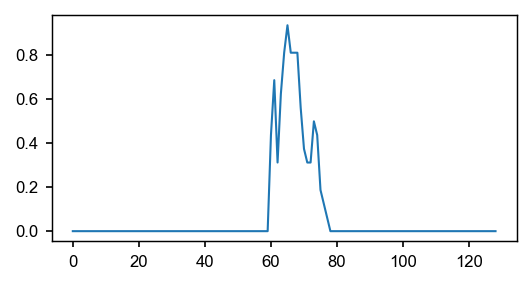

In [15]:
plt.plot(np.nanmean(ex.g_a['mb_ad_cen_g'][0][0, 0, :, :], axis=0))

In [16]:
np.arange(-140, 116+1, 2)

array([-140, -138, -136, -134, -132, -130, -128, -126, -124, -122, -120,
       -118, -116, -114, -112, -110, -108, -106, -104, -102, -100,  -98,
        -96,  -94,  -92,  -90,  -88,  -86,  -84,  -82,  -80,  -78,  -76,
        -74,  -72,  -70,  -68,  -66,  -64,  -62,  -60,  -58,  -56,  -54,
        -52,  -50,  -48,  -46,  -44,  -42,  -40,  -38,  -36,  -34,  -32,
        -30,  -28,  -26,  -24,  -22,  -20,  -18,  -16,  -14,  -12,  -10,
         -8,   -6,   -4,   -2,    0,    2,    4,    6,    8,   10,   12,
         14,   16,   18,   20,   22,   24,   26,   28,   30,   32,   34,
         36,   38,   40,   42,   44,   46,   48,   50,   52,   54,   56,
         58,   60,   62,   64,   66,   68,   70,   72,   74,   76,   78,
         80,   82,   84,   86,   88,   90,   92,   94,   96,   98,  100,
        102,  104,  106,  108,  110,  112,  114,  116])

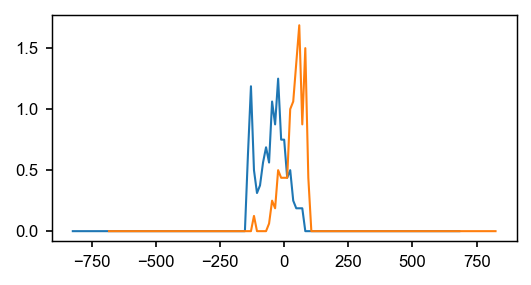

In [17]:
plt.plot(np.arange(-128-12, 128-12+1, 2)*(100/17), np.nanmean(ex.g_a['mb_ad_cen_g'][3][0, 0, :, :], axis=0))
plt.plot(np.arange(128+12, -128+12-1, -2)*(100/17), np.nanmean(ex.g_a['mb_ad_cen_g'][3][1, 0, :, :], axis=0))

In [66]:
np.random.seed(101)
cell_rand_ind = np.round(np.random.rand(4) * 60)
cell_rand_ind

array([31., 34.,  2., 10.])

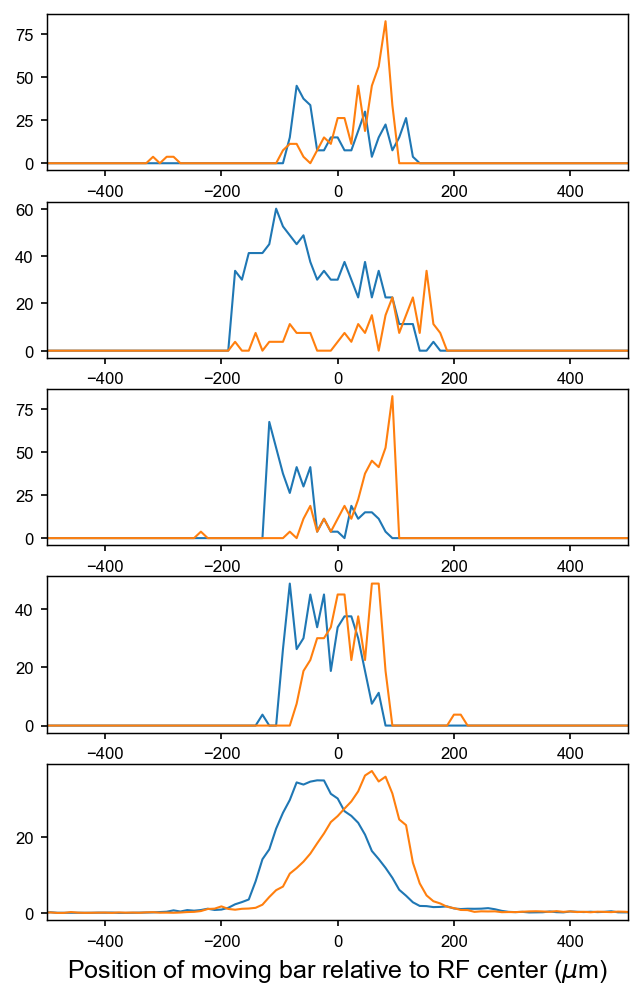

In [76]:
fig = plt.figure(figsize=(5, 8))
for i in range(4):
    ax = plt.subplot(5, 1, i+1)
    ax.plot(np.arange(-128-12, 128-12+1, 2)*(100/17), np.nanmean(ex.g_a['mb_ad_cen_g'][int(cell_rand_ind[i])][0, 0, :, :], axis=0)/(1/60))
    ax.plot(np.arange(128+12, -128+12-1, -2)*(100/17), np.nanmean(ex.g_a['mb_ad_cen_g'][int(cell_rand_ind[i])][1, 0, :, :], axis=0)/(1/60))
    ax.set_xlim([-500, 500])

ax = plt.subplot(5, 1, 5)
ax.plot(np.arange(-128-12, 128-12+1, 2)*(100/17), np.nanmean(np.stack([np.nanmean(ex.g_a['mb_ad_cen_g'][g][0, 0, :, :], axis=0) for g in range(110)]), axis=0)/(1/60))
ax.plot(np.arange(128+12, -128+12-1, -2)*(100/17), np.nanmean(np.stack([np.nanmean(ex.g_a['mb_ad_cen_g'][g][1, 0, :, :], axis=0) for g in range(110)]), axis=0)/(1/60))
ax.set_xlim([-500, 500])
ax.set_xlabel('Position of moving bar relative to RF center ($\mu$m)')

#plt.savefig('fig_bar_position_fr', bbox_inches='tight', dpi=300)

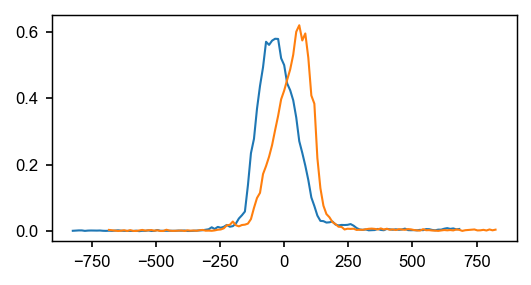

In [42]:
plt.plot(np.arange(-128-12, 128-12+1, 2)*(100/17), np.nanmean(np.stack([np.nanmean(ex.g_a['mb_ad_cen_g'][g][0, 0, :, :], axis=0) for g in range(110)]), axis=0))
plt.plot(np.arange(128+12, -128+12-1, -2)*(100/17), np.nanmean(np.stack([np.nanmean(ex.g_a['mb_ad_cen_g'][g][1, 0, :, :], axis=0) for g in range(110)]), axis=0))

In [ ]:
######################################################################3

## 2. Analyze moving bar data

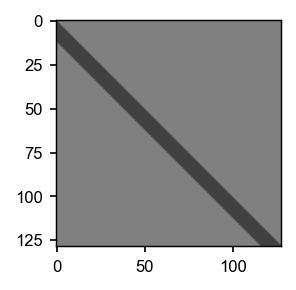

In [13]:
bar_st = st.downsample(ex.stim['mb'][0].astype('double').T, 2)[0].T
bar_st[bar_st == 63] = -0.5
bar_st[bar_st == 127] = 0
plt.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)

### 2-01. Extract ganglion and intracell index (class) to analyze

In [14]:
ex.g['mb_ad'][0].shape # (['l->r of r->l', 'con/amp/dim', 'trial', 'time'])

(2, 3, 32, 129)

In [15]:
ex.i['mb'][0].shape, ex.i['mb_ad_ao'][0].shape

((2, 20, 21500), (2, 3, 32, 21500))

In [16]:
print(np.array(list(df)))

['exp_id' 'exp_date' 'exp_name' 'exp_version' 'sort_version_num'
 'retina_idx' 'intracell_idx' 'g_cell_num' 'g_cell_id' 'flash_1' 'rf_wn'
 'mb_ns' 'mb_ad' 'mb_da' 'mb_2ad' 'mb_4ad' 'mb_2da' 'mb_4da' 'rf_30m'
 'sort_exp_num' 'line_w4' 'idx1_line_w4' 'idx2_line_w4' 'line_w8'
 'idx1_line_w8' 'idx2_line_w8' 'rf_5m' 'idx1_rf_5m' 'idx2_rf_5m' 'mb'
 'flash_2' 'mb_ad_ao' 'flash_1_th' 'rf_wn_th' 'mb_ns_th' 'mb_ad_th'
 'mb_da_th' 'mb_2ad_th' 'mb_4ad_th' 'mb_2da_th' 'mb_4da_th' 'rf_30m_th'
 'line_w4_th' 'line_w8_th' 'rf_5m_th' 'mb_th' 'flash_2_th' 'f_rf'
 'g_rf_size' 'i_rf_size' 'cen_g_idx1' 'cen_g_idx2' 'cen_i_idx1'
 'cen_i_idx2' 'i_g_idx1' 'i_g_idx2' 'i_g_dist' 'g_classify_idx'
 'i_classify_idx' 'g_fr_rf_30m' 'use_half_con_trial' 'mb_1_con_cc_pair'
 'mb_2_con_cc_pair' 'mb_4_con_cc_pair' 'g_mb_con_cc_pair' 'fr_mb_1_con'
 'fr_mb_2_con' 'fr_mb_4_con' 'g_fr_mb_con' 'g_flash_cc_pair'
 'g_fr_flash_on' 'g_fr_flash_off' 'g_fr_flash' 'i_mb_cc_pair'
 'i_flash_cc_pair' 'g_spk_mb_ns' 'g_spk_rf_wn' 'g_delt_

In [17]:
# g_class fastest (0 -> 4 -> 1) slow

In [18]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_01_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
#                    (df['i_g_idx1'] < 150 * (17/100)) & (df['i_g_idx1'] > -150 * (17/100)) &
                    (df['i_g_dist'] < 300) &
#                   location index is roughly at rf center
                    (df['f_rf'] == 1) & 
#                   ganglion cell rf center
                    (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                    (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                    (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                    (df['g_mb_con_cc_pair'] > 0.12) &
                    (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                    (df['i_mb_lin_line_cc_mean'] > 0.6) 
#                    (~(df['exp_id'] == 1) & ~(df['exp_id'] == 9))
                   ].index
class_01_idx_i = df.iloc[class_01_idx_g]['exp_id'].unique()
class_01_idx_g.shape, class_01_idx_i.shape

((94,), (12,))

### 2-02. Align, process and organize dataset

In [19]:
# 'I'-center

In [20]:
ex.g_a['mb_ad_cen_i'][0][0].shape

(3, 32, 129)

In [21]:
def analyze1_g_mb_st_cen_i(mb_num_space_bins=128, 
                          g_list=[],
                          ex=ex,
                          df=df, 
                          mode='session'): 
    i_list = df.iloc[g_list]['exp_id'].unique()
    g_mb_1_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_2_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_4_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_all_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_ns_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_lin_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    g_mb_ln_st_cen_i_list = [[] for i in range(mb_num_space_bins)]
    
    # make two different matrix depending on the directions and average across cells (separately)
    if mode == 'session':
        for g in g_list:
            if df['g_2px_binspace_idx_cen_i'][g] > 0:
                if not np.isnan(ex.g_a['mb_ad_cen_i'][g]).shape == ():
                    g_mb_1_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g], ex.g_a['mb_da_cen_i'][g]], axis=2))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g], ex.g_a['mb_da_cen_i'][g]], axis=2))
                if not np.isnan(ex.g_a['mb_2ad_cen_i'][g]).shape == ():
                    g_mb_2_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g], ex.g_a['mb_2da_cen_i'][g]], axis=2))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g], ex.g_a['mb_2da_cen_i'][g]], axis=2))
                if not np.isnan(ex.g_a['mb_4ad_cen_i'][g]).shape == ():
                    g_mb_4_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g], ex.g_a['mb_4da_cen_i'][g]], axis=2))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g], ex.g_a['mb_4da_cen_i'][g]], axis=2))
                if not np.isnan(ex.g_a['mb_ns_cen_i'][g]).shape == ():
                    g_mb_ns_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ns_cen_i'][g])
                if not np.isnan(ex.g_a['mb_lin_cen_i'][g]).shape == ():
                    g_mb_lin_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_lin_cen_i'][g])
                if not np.isnan(ex.g_a['mb_ln_cen_i'][g]).shape == ():
                    g_mb_ln_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ln_cen_i'][g])
            else:
                print(g, '-th cell is not at the right range, and this cell will be excluded.')
        g_mb_1_st_cen_i = np.zeros((2, 3, 129, mb_num_space_bins))
        g_mb_2_st_cen_i = np.zeros((2, 3, 129, mb_num_space_bins))
        g_mb_4_st_cen_i = np.zeros((2, 3, 129, mb_num_space_bins))
        g_mb_all_st_cen_i = np.zeros((2, 3, 129, mb_num_space_bins))
        g_mb_ns_st_cen_i = np.zeros((2, 2, 129, mb_num_space_bins))
        g_mb_lin_st_cen_i = np.zeros((2, 1, 129, mb_num_space_bins))
        g_mb_ln_st_cen_i = np.zeros((2, 1, 129, mb_num_space_bins))
        g_mb_1_st_cen_i[:] = np.nan
        g_mb_2_st_cen_i[:] = np.nan
        g_mb_4_st_cen_i[:] = np.nan 
        g_mb_all_st_cen_i[:] = np.nan 
        g_mb_ns_st_cen_i[:] = np.nan
        g_mb_lin_st_cen_i[:] = np.nan
        g_mb_ln_st_cen_i[:] = np.nan
        for s in range(mb_num_space_bins):
            if len(g_mb_1_st_cen_i_list[s]) > 0:
                g_mb_1_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_1_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_2_st_cen_i_list[s]) > 0:
                g_mb_2_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_2_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_4_st_cen_i_list[s]) > 0:
                g_mb_4_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_4_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_all_st_cen_i_list[s]) > 0:
                g_mb_all_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_all_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_ns_st_cen_i_list[s]) > 0:
                g_mb_ns_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_ns_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_lin_st_cen_i_list[s]) > 0:
                g_mb_lin_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_lin_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_ln_st_cen_i_list[s]) > 0:
                g_mb_ln_st_cen_i[:, :, :, s] = np.nanmean(np.stack(g_mb_ln_st_cen_i_list[s]), axis=(0, 3)) / ex.tbins['mb_ad'][0][1]
     #   return g_mb_1_st_cen_i, g_mb_2_st_cen_i, g_mb_4_st_cen_i, g_mb_all_st_cen_i, g_mb_ns_st_cen_i, g_mb_lin_st_cen_i, g_mb_ln_st_cen_i
    
    # average by cells (do not make two different matrix, combine two directions in one matrix)
    else:
        for g in g_list:
            if df['g_2px_binspace_idx_cen_i'][g] > 0:
                if not np.isnan(ex.g_a['mb_ad_cen_i'][g]).shape == ():
                    g_mb_1_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g][0], ex.g_a['mb_da_cen_i'][g][0]], axis=1))
                    g_mb_1_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g][1], ex.g_a['mb_da_cen_i'][g][1]], axis=1))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g][0], ex.g_a['mb_da_cen_i'][g][0]], axis=1))
                    g_mb_all_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_ad_cen_i'][g][1], ex.g_a['mb_da_cen_i'][g][1]], axis=1))
                if not np.isnan(ex.g_a['mb_2ad_cen_i'][g]).shape == ():
                    g_mb_2_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g][0], ex.g_a['mb_2da_cen_i'][g][0]], axis=1))
                    g_mb_2_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g][1], ex.g_a['mb_2da_cen_i'][g][1]], axis=1))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g][0], ex.g_a['mb_2da_cen_i'][g][0]], axis=1))
                    g_mb_all_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_2ad_cen_i'][g][1], ex.g_a['mb_2da_cen_i'][g][1]], axis=1))
                if not np.isnan(ex.g_a['mb_4ad_cen_i'][g]).shape == ():
                    g_mb_4_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g][0], ex.g_a['mb_4da_cen_i'][g][0]], axis=1))
                    g_mb_4_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g][1], ex.g_a['mb_4da_cen_i'][g][1]], axis=1))
                    g_mb_all_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g][0], ex.g_a['mb_4da_cen_i'][g][0]], axis=1))
                    g_mb_all_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(np.concatenate([ex.g_a['mb_4ad_cen_i'][g][1], ex.g_a['mb_4da_cen_i'][g][1]], axis=1))
                if not np.isnan(ex.g_a['mb_ns_cen_i'][g]).shape == ():
                    g_mb_ns_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ns_cen_i'][g][0])
                    g_mb_ns_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ns_cen_i'][g][1])
                if not np.isnan(ex.g_a['mb_lin_cen_i'][g]).shape == ():
                    g_mb_lin_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_lin_cen_i'][g][0])
                    g_mb_lin_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_lin_cen_i'][g][1])
                if not np.isnan(ex.g_a['mb_ln_cen_i'][g]).shape == ():
                    g_mb_ln_st_cen_i_list[df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ln_cen_i'][g][0])
                    g_mb_ln_st_cen_i_list[127 - df['g_2px_binspace_idx_cen_i'][g]].append(ex.g_a['mb_ln_cen_i'][g][1])
            else:
                print(g, '-th cell is not at the right range, and this cell will be excluded.')
        g_mb_1_st_cen_i = np.zeros((3, 129, mb_num_space_bins))
        g_mb_2_st_cen_i = np.zeros((3, 129, mb_num_space_bins))
        g_mb_4_st_cen_i = np.zeros((3, 129, mb_num_space_bins))
        g_mb_all_st_cen_i = np.zeros((3, 129, mb_num_space_bins))
        g_mb_ns_st_cen_i = np.zeros((2, 129, mb_num_space_bins))
        g_mb_lin_st_cen_i = np.zeros((1, 129, mb_num_space_bins))
        g_mb_ln_st_cen_i = np.zeros((1, 129, mb_num_space_bins))
        g_mb_1_st_cen_i[:] = np.nan
        g_mb_2_st_cen_i[:] = np.nan
        g_mb_4_st_cen_i[:] = np.nan 
        g_mb_all_st_cen_i[:] = np.nan 
        g_mb_ns_st_cen_i[:] = np.nan
        g_mb_lin_st_cen_i[:] = np.nan
        g_mb_ln_st_cen_i[:] = np.nan
        for s in range(mb_num_space_bins):
            if len(g_mb_1_st_cen_i_list[s]) > 0:
                g_mb_1_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_1_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_2_st_cen_i_list[s]) > 0:
                g_mb_2_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_2_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_4_st_cen_i_list[s]) > 0:
                g_mb_4_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_4_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_all_st_cen_i_list[s]) > 0:
                g_mb_all_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_all_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_ns_st_cen_i_list[s]) > 0:
                g_mb_ns_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_ns_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_lin_st_cen_i_list[s]) > 0:
                g_mb_lin_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_lin_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]
            if len(g_mb_ln_st_cen_i_list[s]) > 0:
                g_mb_ln_st_cen_i[:, :, s] = np.nanmean(np.stack(g_mb_ln_st_cen_i_list[s]), axis=(0, 2)) / ex.tbins['mb_ad'][0][1]                    
    return g_mb_1_st_cen_i, g_mb_2_st_cen_i, g_mb_4_st_cen_i, g_mb_all_st_cen_i, g_mb_ns_st_cen_i, g_mb_lin_st_cen_i, g_mb_ln_st_cen_i

In [22]:
[c01_g_mb_1_st_cen_i_s, 
 c01_g_mb_2_st_cen_i_s, 
 c01_g_mb_4_st_cen_i_s, 
 c01_g_mb_all_st_cen_i_s, 
 c01_g_mb_ns_st_cen_i_s, 
 c01_g_mb_lin_st_cen_i_s, 
 c01_g_mb_ln_st_cen_i_s] = analyze1_g_mb_st_cen_i(mb_num_space_bins=128, 
                                                  g_list=class_01_idx_g, 
                                                  ex=ex, 
                                                  df=df, 
                                                  mode='session')
[c01_g_mb_1_st_cen_i_c, 
 c01_g_mb_2_st_cen_i_c, 
 c01_g_mb_4_st_cen_i_c, 
 c01_g_mb_all_st_cen_i_c, 
 c01_g_mb_ns_st_cen_i_c,
 c01_g_mb_lin_st_cen_i_c, 
 c01_g_mb_ln_st_cen_i_c] = analyze1_g_mb_st_cen_i(mb_num_space_bins=128, 
                                                  g_list=class_01_idx_g, 
                                                  ex=ex, 
                                                  df=df, 
                                                  mode='cells')
c01_i_mb_cen_i = np.stack([ex.i_a['mb_cen_i'][i, :, 0, :, :] for i in class_01_idx_i])
c01_i_mb_ao_cen_i = np.stack([ex.i_a['mb_ao_cen_i'][i, :, 1, :, :] for i in class_01_idx_i])

In [23]:
c01_g_mb_1_st_cen_i_s.shape, c01_g_mb_1_st_cen_i_c.shape, c01_i_mb_cen_i.shape, c01_i_mb_ao_cen_i.shape

((2, 3, 129, 128), (3, 129, 128), (12, 2, 20, 129), (12, 2, 32, 129))

### 2-03. Analyze by experimental session ['a1', 'a2', 'a4', 'all', 'ns', 'lin', 'ln'] (by cell / by session)

In [24]:
g_mb_exp_list = ['1', '2', '4', 'all', 'ns', 'lin', 'ln']
g_mb_exp_idx = 0

In [25]:
def analyze2_g_mb_st_cen_i(d1_s, d2_s, d4_s, dall_s, dns_s, dlin_s, dln_s,
                           d1_c, d2_c, d4_c, dall_c, dns_c, dlin_c, dln_c,
                           stim_list=g_mb_exp_list): 
    d = {}
    d['s'] = {}
    d['c'] = {}
    d['s']['1'] = copy.deepcopy(d1_s)
    d['s']['2'] = copy.deepcopy(d2_s)
    d['s']['4'] = copy.deepcopy(d4_s)
    d['s']['all'] = copy.deepcopy(dall_s)
    d['s']['ns'] = copy.deepcopy(dns_s)
    d['s']['lin'] = copy.deepcopy(dlin_s)
    d['s']['ln'] = copy.deepcopy(dln_s)
    d['c']['1'] = copy.deepcopy(d1_c)
    d['c']['2'] = copy.deepcopy(d2_c)
    d['c']['4'] = copy.deepcopy(d4_c)
    d['c']['all'] = copy.deepcopy(dall_c)
    d['c']['ns'] = copy.deepcopy(dns_c)
    d['c']['lin'] = copy.deepcopy(dlin_c)
    d['c']['ln'] = copy.deepcopy(dln_c)
    
    gm = {}       #g_mat_st_cen_i_
    gm['s'] = {}  #               s
    gm['c'] = {}  #               c
    
    for li in stim_list:
        gm['s'][li] = {}
        gm['c'][li] = {}
        if li == 'ns':
            gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
            gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
            gm['s'][li]['diff_l'] = d['s'][li][0, 0, :, :] - d['s'][li][0, 1, :, :]
            gm['s'][li]['diff_r'] = d['s'][li][1, 0, :, :] - d['s'][li][1, 1, :, :]
            gm['s'][li]['diff'] = np.nanmean(np.stack([gm['s'][li]['diff_l'], gm['s'][li]['diff_r'][:, ::-1]]), axis=0)
            gm['c'][li]['amp'] = d['c'][li][0, :, :]
            gm['c'][li]['dim'] = d['c'][li][1, :, :]
            gm['c'][li]['diff'] = d['c'][li][0, :, :] - d['c'][li][1, :, :]
        elif li == 'lin':
            gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
            gm['c'][li]['con'] = d['c'][li][0, :, :]
        elif li == 'ln':
            gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
            gm['c'][li]['con'] = d['c'][li][0, :, :]
        else:
            gm['s'][li]['con_l'] = d['s'][li][0, 0, :, :]
            gm['s'][li]['con_r'] = d['s'][li][1, 0, :, :]
            gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
            gm['s'][li]['amp_l'] = d['s'][li][0, 1, :, :]
            gm['s'][li]['amp_r'] = d['s'][li][1, 1, :, :]
            gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
            gm['s'][li]['dim_l'] = d['s'][li][0, 2, :, :]
            gm['s'][li]['dim_r'] = d['s'][li][1, 2, :, :]
            gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
            gm['c'][li]['con'] = d['c'][li][0, :, :]
            gm['c'][li]['amp'] = d['c'][li][1, :, :]
            gm['c'][li]['dim'] = d['c'][li][2, :, :]
            
            gm['s'][li]['amp_con_l'] = d['s'][li][0, 1, :, :] - d['s'][li][0, 0, :, :]
            gm['s'][li]['amp_con_r'] = d['s'][li][1, 1, :, :] - d['s'][li][1, 0, :, :]
            gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
            gm['s'][li]['dim_con_l'] = d['s'][li][0, 2, :, :] - d['s'][li][0, 0, :, :]
            gm['s'][li]['dim_con_r'] = d['s'][li][1, 2, :, :] - d['s'][li][1, 0, :, :]
            gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
            gm['s'][li]['diff_l'] = d['s'][li][0, 1, :, :] - d['s'][li][0, 2, :, :]
            gm['s'][li]['diff_r'] = d['s'][li][1, 1, :, :] - d['s'][li][1, 2, :, :]
            gm['s'][li]['diff'] = np.nanmean(np.stack([gm['s'][li]['diff_l'], gm['s'][li]['diff_r'][:, ::-1]]), axis=0)
            gm['c'][li]['amp_con'] = d['c'][li][1, :, :] - d['c'][li][0, :, :]
            gm['c'][li]['dim_con'] = d['c'][li][2, :, :] - d['c'][li][0, :, :]
            gm['c'][li]['diff'] = d['c'][li][1, :, :] - d['c'][li][2, :, :]
    return copy.deepcopy(gm)

In [26]:
c01_g_mat_cen_i = analyze2_g_mb_st_cen_i(c01_g_mb_1_st_cen_i_s, c01_g_mb_2_st_cen_i_s, c01_g_mb_4_st_cen_i_s, c01_g_mb_all_st_cen_i_s, c01_g_mb_ns_st_cen_i_s, c01_g_mb_lin_st_cen_i_s, c01_g_mb_ln_st_cen_i_s,
                                         c01_g_mb_1_st_cen_i_c, c01_g_mb_2_st_cen_i_c, c01_g_mb_4_st_cen_i_c, c01_g_mb_all_st_cen_i_c, c01_g_mb_ns_st_cen_i_c, c01_g_mb_lin_st_cen_i_c, c01_g_mb_ln_st_cen_i_c,
                                         stim_list=g_mb_exp_list)

<ipython-input-25-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

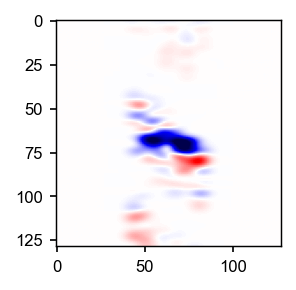

In [27]:
plt.imshow(smooth(nn(c01_g_mat_cen_i['c']['1']['diff']), 2, 4), cmap='seismic', vmin=-1, vmax=1)

In [28]:
def plot_ts_mat(mat, stim_list='1', s1=0, s2=0):
    li = stim_list
    
    fig = plt.figure(figsize=(5, 5))
    ax = plt.subplot(4, 4, 1)
    im = ax.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 2)
    im = ax.imshow(bar_st[:, ::-1], cmap='gray', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 4)
    im = ax.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)

    ax = plt.subplot(4, 4, 5)
    im = ax.imshow(nn(mat['s'][li]['con_l']), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con_l']))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 6)
    im = ax.imshow(nn(mat['s'][li]['con_r']), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con_r']))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 7)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(mat['s'][li]['con']), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con']), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 8)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(mat['c'][li]['con']), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['c'][li]['con']), alpha=0.8)
    fig.colorbar(im, ax=ax)

    ax = plt.subplot(4, 4, 9)
    im = ax.imshow(nn(mat['s'][li]['diff_l']), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff_l'])), vmax=np.nanmax(abs(mat['s'][li]['diff_l'])))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 10)
    im = ax.imshow(nn(mat['s'][li]['diff_r']), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff_r'])), vmax=np.nanmax(abs(mat['s'][li]['diff_r'])))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 11)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(mat['s'][li]['diff']), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff'])), vmax=np.nanmax(abs(mat['s'][li]['diff'])), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 12)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(mat['c'][li]['diff']), cmap='seismic', vmin=-np.nanmax(abs(mat['c'][li]['diff'])), vmax=np.nanmax(abs(mat['c'][li]['diff'])), alpha=0.8)
    fig.colorbar(im, ax=ax)

    
    mat1 = smooth(nn(mat['s'][li]['diff_l']), s1, s2)
    mat2 = smooth(nn(mat['s'][li]['diff_r']), s1, s2)
    mat3 = smooth(nn(mat['s'][li]['diff']), s1, s2)
    mat4 = smooth(nn(mat['c'][li]['diff']), s1, s2)
    ax = plt.subplot(4, 4, 13)
    im = ax.imshow(mat1, cmap='seismic', vmin=-np.nanmax(abs(mat1)), vmax=np.nanmax(abs(mat1)))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 14)
    im = ax.imshow(mat2, cmap='seismic', vmin=-np.nanmax(abs(mat2)), vmax=np.nanmax(abs(mat2)))
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 15)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(mat3, cmap='seismic', vmin=-np.nanmax(abs(mat3)), vmax=np.nanmax(abs(mat3)), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 4, 16)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(mat4, cmap='seismic', vmin=-np.nanmax(abs(mat4)), vmax=np.nanmax(abs(mat4)), alpha=0.8)
    fig.colorbar(im, ax=ax)

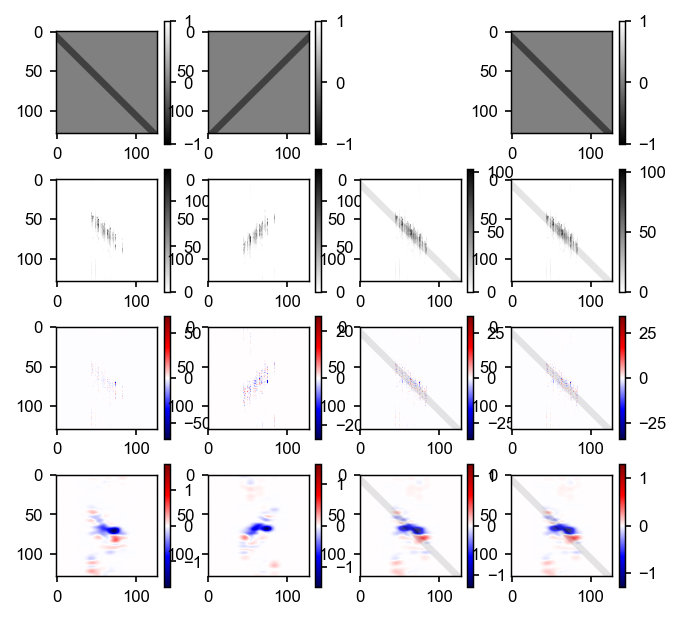

In [29]:
plot_ts_mat(mat=c01_g_mat_cen_i, stim_list='1', s1=2, s2=4)

In [30]:
def plot_st_mat_zoom(mat, stim_list='1', s1=0, s2=0):
    li = stim_list
   
    pr = 30
    st_ext = [-ex.tbins['mb_ad'][0][1] * 129/2, ex.tbins['mb_ad'][0][1] * 129/2, -256 * (100/17) / 2, 256 * (100/17) / 2]
    t_lim = [-pr * ex.tbins['mb_ad'][0][1], pr * ex.tbins['mb_ad'][0][1]]
    s_lim = [-pr * 2 * (100/17), pr * 2 * (100/17)]
    
    fig = plt.figure(figsize=(5, 4))
    ax = plt.subplot(4, 4, 1)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=-1, vmax=1, extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 2)
    im = ax.imshow(ts2st(bar_st[:, ::-1]), cmap='gray', vmin=-1, vmax=1, extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 4)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=-1, vmax=1, extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)

    ax = plt.subplot(4, 4, 5)
    im = ax.imshow(ts2st(nn(mat['s'][li]['con_l'])), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con_l']), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 6)
    im = ax.imshow(ts2st(nn(mat['s'][li]['con_r'])), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con_r']), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 7)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(nn(mat['s'][li]['con'])), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['s'][li]['con']), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 8)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(nn(mat['c'][li]['con'])), cmap='gray_r', vmin=0, vmax=np.nanmax(mat['c'][li]['con']), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)

    ax = plt.subplot(4, 4, 9)
    im = ax.imshow(ts2st(nn(mat['s'][li]['diff_l'])), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff_l'])), vmax=np.nanmax(abs(mat['s'][li]['diff_l'])), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 10)
    im = ax.imshow(ts2st(nn(mat['s'][li]['diff_r'])), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff_r'])), vmax=np.nanmax(abs(mat['s'][li]['diff_r'])), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 11)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(nn(mat['s'][li]['diff'])), cmap='seismic', vmin=-np.nanmax(abs(mat['s'][li]['diff'])), vmax=np.nanmax(abs(mat['s'][li]['diff'])), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 12)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(nn(mat['c'][li]['diff'])), cmap='seismic', vmin=-np.nanmax(abs(mat['c'][li]['diff'])), vmax=np.nanmax(abs(mat['c'][li]['diff'])), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)

    mat1 = smooth(nn(mat['s'][li]['diff_l']), s1, s2)
    mat2 = smooth(nn(mat['s'][li]['diff_r']), s1, s2)
    mat3 = smooth(nn(mat['s'][li]['diff']), s1, s2)
    mat4 = smooth(nn(mat['c'][li]['diff']), s1, s2)
    ax = plt.subplot(4, 4, 13)
    im = ax.imshow(ts2st(mat1), cmap='seismic', vmin=-np.nanmax(abs(mat1)), vmax=np.nanmax(abs(mat1)), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 14)
    im = ax.imshow(ts2st(mat2), cmap='seismic', vmin=-np.nanmax(abs(mat2)), vmax=np.nanmax(abs(mat2)), extent=st_ext, aspect='auto', interpolation='nearest')
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 15)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(mat3), cmap='seismic', vmin=-np.nanmax(abs(mat3)), vmax=np.nanmax(abs(mat3)), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    ax = plt.subplot(4, 4, 16)
    im = ax.imshow(ts2st(bar_st), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.5)
    im = ax.imshow(ts2st(mat4), cmap='seismic', vmin=-np.nanmax(abs(mat4)), vmax=np.nanmax(abs(mat4)), extent=st_ext, aspect='auto', interpolation='nearest', alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax.set_xlim(t_lim)
    ax.set_ylim(s_lim)
    
    plt.tight_layout(pad=0.5)

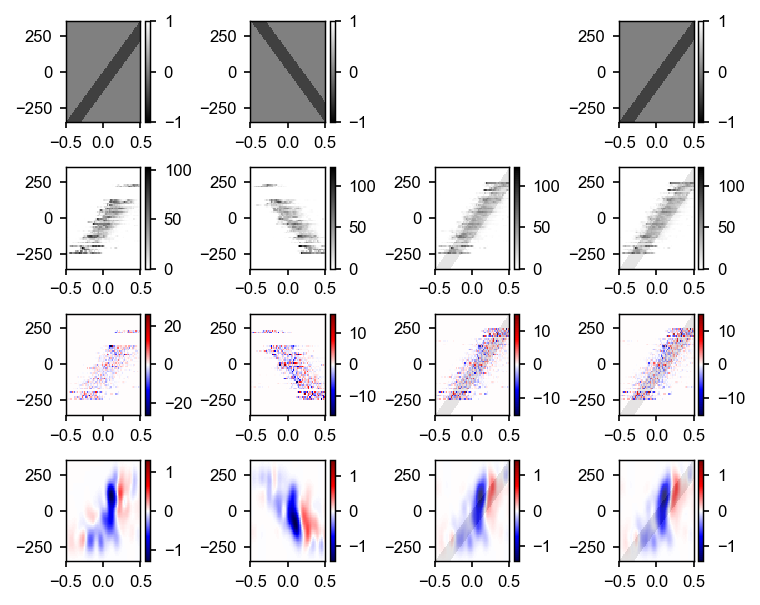

In [31]:
plot_st_mat_zoom(mat=c01_g_mat_cen_i, stim_list='all', s1=2, s2=4)

### 2-04. Spatiotemporal transformation

In [32]:
def tr(mat, pad='nan'):
    if pad == 'zero':
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant')[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    else:
        mat_tr = np.stack([np.roll(np.pad(mat, ((0, 0), (70, 70)), mode='constant', constant_values=(np.nan, np.nan))[t, :], 64-t)[70:-70] for t in range(mat.shape[0])])
    return copy.deepcopy(mat_tr)

In [33]:
def analyze3_g_mb_st_cen_i(gm, stim_list=g_mb_exp_list, s1=0, s2=0):
    gmtr = {}
    gmtr['s'] = {}
    gmtr['c'] = {}
    for li in stim_list:
        gmtr['s'][li] = {}
        gmtr['c'][li] = {}
        if li == 'ns':
            gmtr['s'][li]['amp'] = tr(gm['s'][li]['amp'])
            gmtr['s'][li]['dim'] = tr(gm['s'][li]['dim'])
            gmtr['s'][li]['diff'] = tr(gm['s'][li]['diff'])
            gmtr['c'][li]['amp'] = tr(gm['c'][li]['amp'])
            gmtr['c'][li]['dim'] = tr(gm['c'][li]['dim'])
            gmtr['c'][li]['diff'] = tr(gm['c'][li]['diff'])
            gmtr['s'][li]['diff_sm'] = tr(smooth(nn(gm['s'][li]['diff']), s1=s1, s2=s2))
            gmtr['c'][li]['diff_sm'] = tr(smooth(nn(gm['c'][li]['diff']), s1=s1, s2=s2))
        elif li == 'lin':
            gmtr['s'][li]['con'] = tr(gm['s'][li]['con'])
            gmtr['c'][li]['con'] = tr(gm['c'][li]['con'])
        elif li == 'ln':
            gmtr['s'][li]['con'] = tr(gm['s'][li]['con'])
            gmtr['c'][li]['con'] = tr(gm['c'][li]['con'])
        else:
            gmtr['s'][li]['con'] = tr(gm['s'][li]['con'])
            gmtr['s'][li]['amp'] = tr(gm['s'][li]['amp'])
            gmtr['s'][li]['dim'] = tr(gm['s'][li]['dim'])
            gmtr['c'][li]['con'] = tr(gm['c'][li]['con'])
            gmtr['c'][li]['amp'] = tr(gm['c'][li]['amp'])
            gmtr['c'][li]['dim'] = tr(gm['c'][li]['dim'])
            
            gmtr['s'][li]['diff'] = tr(gm['s'][li]['diff'])
            gmtr['c'][li]['amp_con'] = tr(gm['c'][li]['amp_con'])
            gmtr['c'][li]['dim_con'] = tr(gm['c'][li]['dim_con'])
            gmtr['c'][li]['diff'] = tr(gm['c'][li]['diff'])
            gmtr['s'][li]['diff_sm'] = tr(smooth(nn(gm['s'][li]['diff']), s1=s1, s2=s2))   # smoothed
            gmtr['c'][li]['amp_con_sm'] = tr(smooth(nn(gm['c'][li]['amp_con']), s1=s1, s2=s2))
            gmtr['c'][li]['dim_con_sm'] = tr(smooth(nn(gm['c'][li]['dim_con']), s1=s1, s2=s2))
            gmtr['c'][li]['diff_sm'] = tr(smooth(nn(gm['c'][li]['diff']), s1=s1, s2=s2))
            gmtr['c'][li]['diff_sm_slice'] = {}
            for t in range(5):
                idx1 = 9 * t + 42
                idx2 = idx1 + 9
                gmtr['c'][li]['diff_sm_slice'][t] = tr(smooth(nn(gm['c'][li]['diff']), s1=s1, s2=s2))[idx1:idx2, :]
    return copy.deepcopy(gmtr)

In [34]:
c01_g_mat_tr_cen_i = analyze3_g_mb_st_cen_i(c01_g_mat_cen_i, stim_list=g_mb_exp_list, s1=0, s2=0)

In [35]:
def plot_ts_mat_tr(gm, gmtr, stim_list='1', s1=0, s2=0):
    li = stim_list
    
    fig = plt.figure(figsize=(3, 4))
    ax = plt.subplot(4, 2, 1)
    im = ax.imshow(bar_st, cmap='gray', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 2, 2)
    im = ax.imshow(tr(bar_st, pad='zero'), cmap='gray', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)

    ax = plt.subplot(4, 2, 3)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(gm['c'][li]['con']), cmap='gray_r', vmin=0, vmax=np.nanmax(gm['c'][li]['con']), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 2, 4)
    im = ax.imshow(tr(bar_st, pad='zero'), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(gmtr['c'][li]['con']), cmap='gray_r', vmin=0, vmax=np.nanmax(gmtr['c'][li]['con']), alpha=0.8)
    fig.colorbar(im, ax=ax)

    ax = plt.subplot(4, 2, 5)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(gm['c'][li]['diff']), cmap='seismic', vmin=-np.nanmax(abs(gm['c'][li]['diff'])), vmax=np.nanmax(abs(gm['c'][li]['diff'])), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 2, 6)
    im = ax.imshow(tr(bar_st, pad='zero'), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(nn(gmtr['c'][li]['diff']), cmap='seismic', vmin=-np.nanmax(abs(gmtr['c'][li]['diff'])), vmax=np.nanmax(abs(gmtr['c'][li]['diff'])), alpha=0.8)
    fig.colorbar(im, ax=ax)

    mat1 = smooth(nn(gm['c'][li]['diff']), s1, s2)
    mat2 = tr(smooth(nn(gm['c'][li]['diff']), s1, s2))
    ax = plt.subplot(4, 2, 7)
    im = ax.imshow(bar_st, cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(mat1, cmap='seismic', vmin=-np.nanmax(abs(mat1)), vmax=np.nanmax(abs(mat1)), alpha=0.8)
    fig.colorbar(im, ax=ax)
    ax = plt.subplot(4, 2, 8)
    im = ax.imshow(tr(bar_st, pad='zero'), cmap='gray', vmin=np.min(bar_st), vmax=np.max(bar_st), alpha=0.5)
    im = ax.imshow(mat2, cmap='seismic', vmin=-np.nanmax(abs(mat2)), vmax=np.nanmax(abs(mat2)), alpha=0.8)
    fig.colorbar(im, ax=ax)
    
    plt.tight_layout(pad=0.5)

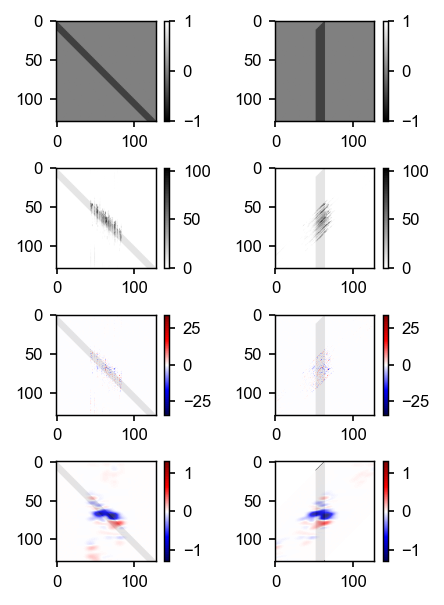

In [36]:
plot_ts_mat_tr(c01_g_mat_cen_i, c01_g_mat_tr_cen_i, stim_list='1', s1=2, s2=4)

In [37]:
def plot_ts_mat_tr_mean(gmtr, stim_list='1', s1=0):
    li = stim_list
    fig = plt.figure(figsize=(3, 3))
    
    ax = plt.subplot(411)
    ax.plot(np.nanmean(tr(bar_st), 0), 'k')
    ax.set_ylim([-1, 1])
    
    ax = plt.subplot(412)
    ax.plot(np.nanmean(gmtr['c']['1']['con'], 0), 'r')
    ax.plot(np.nanmean(gmtr['c']['2']['con'], 0), 'b')
    #ax.plot(np.nanmean(gmtr['c']['4']['con'], 0), 'k')
    
    ax = plt.subplot(413)
    ax.plot(smooth_1d(np.nanmean(gmtr['c']['1']['diff_sm'], 0), s1), 'r')
    ax.plot(smooth_1d(np.nanmean(gmtr['c']['2']['diff_sm'], 0), s1), 'b')
    #ax.plot(smooth_1d(np.nanmean(gmtr['c']['4']['diff_sm'], 0), s1), 'k')
 
    plt.tight_layout()

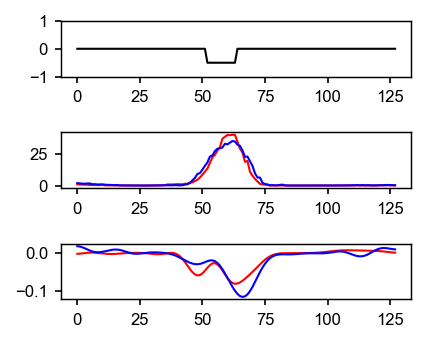

In [38]:
plot_ts_mat_tr_mean(c01_g_mat_tr_cen_i, stim_list='1', s1=4)

### 2-05. Unified analysis function

In [39]:
def analyzeall_g_mb_st_cen_i(mb_num_space_bins=128, g_list=[], ex=ex, df=df, stim_list=g_mb_exp_list, s1=0, s2=0):
    [d1_s, d2_s, d4_s, dall_s, dns_s, dlin_s, dln_s] = analyze1_g_mb_st_cen_i(mb_num_space_bins=mb_num_space_bins, g_list=g_list, ex=ex, df=df, mode='session')
    [d1_c, d2_c, d4_c, dall_c, dns_c, dlin_c, dln_c] = analyze1_g_mb_st_cen_i(mb_num_space_bins=mb_num_space_bins, g_list=g_list, ex=ex, df=df, mode='cells')
    gm = analyze2_g_mb_st_cen_i(d1_s, d2_s, d4_s, dall_s, dns_s, dlin_s, dln_s, d1_c, d2_c, d4_c, dall_c, dns_c, dlin_c, dln_c, stim_list=stim_list)
    gmtr = analyze3_g_mb_st_cen_i(gm, stim_list=stim_list, s1=s1, s2=s2)
    return gm, gmtr

### 2-06. Analysis for intracell

In [40]:
i_mb_exp_list = ['all', 'lin']

In [41]:
# intracell projective field map 
def analyze_i_mb_st_cen_i(i_list=[], ex=ex, df=df, stim_list=i_mb_exp_list, s1=0, s2=0):
    # 1
    i_mb_proj_st_cen_i = np.nanmean(np.stack([np.outer(-np.roll(np.nanmean(ex.i_a['mb_baseline0_cen_i'][i], (0, 1, 2)), 2), 
                                                       space_prop) for i in i_list]), axis=0)[None, :, :]
    i_mb_lin_proj_st_cen_i = np.nanmean(np.stack([np.outer(-np.roll(np.nanmean(ex.i_a['mb_lin_line_baseline0_cen_i'][i], (0, 1, 2)), 2), 
                                                           space_prop) for i in i_list]), axis=0)[None, :, :]
    # 2
    f = {}
    f['c'] = {}
    f['c']['all'] = copy.deepcopy(i_mb_proj_st_cen_i)
    f['c']['lin'] = copy.deepcopy(i_mb_lin_proj_st_cen_i)
    
    im = {}
    im['c'] ={}
    for li in stim_list:
        im['c'][li] = {}
        im['c'][li]['proj'] = f['c'][li][0, :, :]
        im['c'][li]['proj_sm'] = smooth(f['c'][li][0, :, :], s1=s1, s2=s2)
        
    # 3
    imtr = {}
    imtr['c'] = {}
    for li in stim_list:
        imtr['c'][li] = {}
        imtr['c'][li]['proj'] = tr(im['c'][li]['proj'])
        imtr['c'][li]['proj_sm'] = tr(smooth(im['c'][li]['proj'], s1=s1, s2=s2))
    return copy.deepcopy(im), copy.deepcopy(imtr)

In [42]:
c01_i_mat_cen_i, c01_i_mat_tr_cen_i = analyze_i_mb_st_cen_i(i_list=df.iloc[class_01_idx_g]['exp_id'].unique(), ex=ex, df=df, stim_list=i_mb_exp_list, s1=0, s2=0)

### 3-01. Bootstrap analysis

In [43]:
def bootstrap_g_mb(N=10, g_list=[], seed=0, s1=0, s2=0, class_num=0):
    np.random.seed(seed)
    m = g_list.shape[0]   # same as the total number of ganglion cells
    
    # output
    out = {}
    out['sample'] = {}
    out['bs'] = {}
    out['attrs'] = {}
    out['attrs']['g_list'] = g_list
    out['attrs']['N'] = N
    out['attrs']['seed'] = seed
    out['attrs']['s1'] = s1
    out['attrs']['s2'] = s2
    out['attrs']['class_num'] = class_num
    
    # sample analysis
    gm, gmtr = analyzeall_g_mb_st_cen_i(mb_num_space_bins=128, g_list=g_list, ex=ex, df=df, stim_list=g_mb_exp_list, s1=s1, s2=s2)
    im, imtr = analyze_i_mb_st_cen_i(i_list=df.iloc[g_list]['exp_id'].unique(), ex=ex, df=df, stim_list=i_mb_exp_list, s1=s1, s2=s2)
    out['sample']['gm'] = gm
    out['sample']['gmtr'] = gmtr
    out['sample']['im'] = im
    out['sample']['imtr'] = imtr
    
    # bootstrap analysis (for ganglion cells)
    for i in range(N):
        out['bs'][i] = {}
        out['bs'][i]['gmtr'] = {}
        g_list_sub = np.random.choice(g_list, m, replace=True)
        gm, gmtr = analyzeall_g_mb_st_cen_i(mb_num_space_bins=128, g_list=g_list_sub, ex=ex, df=df, stim_list=g_mb_exp_list, s1=s1, s2=s2)
        #out['bs'][i]['gm'] = gm
        out['bs'][i]['gmtr']['c'] = gmtr['c']
        
    # save the results
    pickle.dump(out, open(proj_dir + 'data-figure/' + 'bootstrap_c' +  "{:02d}".format(class_num) + '.p', 'wb'))
#    return out

### 3-02. Bootstrap anaylsis for each cluster

In [44]:
#                   location index is roughly at rf center
class_00_idx_g_default = ((df['f_rf'] == 1) & 
#                   ganglion cell rf center
                          (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                          (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                          (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                          (df['g_mb_con_cc_pair'] > 0.12) &
                          (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                          (df['i_mb_lin_line_cc_mean'] > 0.6)) 
class_00_idx_g_default.shape

(189,)

In [45]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_01_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_01_idx_i = df.iloc[class_01_idx_g]['exp_id'].unique()
class_01_idx_g.shape, class_01_idx_i.shape

((94,), (12,))

In [46]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_02_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   session
                    (df['mb_ad'] == 1) & (df['mb_ns'] == 1) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_02_idx_i = df.iloc[class_02_idx_g]['exp_id'].unique()
class_02_idx_g.shape, class_02_idx_i.shape

((25,), (3,))

In [47]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_03_idx_g = df[(df['g_classify_idx'] == 0) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                 (df['i_mb_classify_idx'] == 2) |
                                                                                 (df['i_mb_classify_idx'] == 3) |
                                                                                 (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_03_idx_i = df.iloc[class_03_idx_g]['exp_id'].unique()
class_03_idx_g.shape, class_03_idx_i.shape

((30,), (8,))

In [48]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_04_idx_g = df[(df['g_classify_idx'] == 4) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                 (df['i_mb_classify_idx'] == 2) |
                                                                                 (df['i_mb_classify_idx'] == 3) |
                                                                                 (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_04_idx_i = df.iloc[class_04_idx_g]['exp_id'].unique()
class_04_idx_g.shape, class_04_idx_i.shape

((39,), (11,))

In [49]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_05_idx_g = df[(df['g_classify_idx'] == 1) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                 (df['i_mb_classify_idx'] == 2) |
                                                                                 (df['i_mb_classify_idx'] == 3) |
                                                                                 (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_05_idx_i = df.iloc[class_05_idx_g]['exp_id'].unique()
class_05_idx_g.shape, class_05_idx_i.shape

((25,), (9,))

In [50]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_06_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   session
                    (df['mb_ad'] == 1) & (df['mb_2ad'] == 1) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_06_idx_i = df.iloc[class_06_idx_g]['exp_id'].unique()
class_06_idx_g.shape, class_06_idx_i.shape

((25,), (3,))

In [51]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_07_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] > 250) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_07_idx_i = df.iloc[class_07_idx_g]['exp_id'].unique()
class_07_idx_g.shape, class_07_idx_i.shape

((24,), (8,))

In [52]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_08_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 1) & #((df['i_mb_classify_idx'] == 0) | 
                                                                                  # (df['i_mb_classify_idx'] == 2) |
                                                                                  # (df['i_mb_classify_idx'] == 3) |
                                                                                  # (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
                    (df['i_g_dist'] < 300) &
#                   default filter
                    class_00_idx_g_default
                   ].index
class_08_idx_i = df.iloc[class_08_idx_g]['exp_id'].unique()
class_08_idx_g.shape, class_08_idx_i.shape

((14,), (2,))

### 3-03. Bootstrap analysis save

In [55]:
bootstrap_g_mb(N=1000, g_list=class_01_idx_g, seed=101, s1=2, s2=2, class_num=1)  
bootstrap_g_mb(N=1000, g_list=class_02_idx_g, seed=102, s1=2, s2=2, class_num=2)  
bootstrap_g_mb(N=1000, g_list=class_03_idx_g, seed=103, s1=2, s2=2, class_num=3)   
bootstrap_g_mb(N=1000, g_list=class_04_idx_g, seed=104, s1=2, s2=2, class_num=4)   
bootstrap_g_mb(N=1000, g_list=class_05_idx_g, seed=105, s1=2, s2=2, class_num=5)
bootstrap_g_mb(N=1000, g_list=class_06_idx_g, seed=106, s1=2, s2=2, class_num=6)   
bootstrap_g_mb(N=1000, g_list=class_07_idx_g, seed=107, s1=2, s2=2, class_num=7)   
bootstrap_g_mb(N=1000, g_list=class_08_idx_g, seed=108, s1=2, s2=2, class_num=8)   

<ipython-input-25-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

In [ ]:
########################################################################33

In [139]:
distance_arr = np.arange(100, 400, 100)
distance_arr

array([100, 200, 300])

In [140]:
d_out = {}
for distance_idx, distance in enumerate(distance_arr): 
    d_out[distance_idx] = {}
    class_s_idx_g = df[((df['g_classify_idx'] == 0) | 
                        (df['g_classify_idx'] == 1) | 
                        (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                      (df['i_mb_classify_idx'] == 2) |
                                                                                      (df['i_mb_classify_idx'] == 3) |
                                                                                      (df['i_mb_classify_idx'] == 4)) &
#                      distance                             
                       ((df['i_g_dist'] > distance-100) & (df['i_g_dist'] < distance)) &
#                      default filter
                       class_00_idx_g_default
                      ].index
    class_s_idx_i = df.iloc[class_s_idx_g]['exp_id'].unique()
    gm, gmtr = analyzeall_g_mb_st_cen_i(mb_num_space_bins=128, g_list=class_s_idx_g, ex=ex, df=df, stim_list=g_mb_exp_list, s1=0, s2=0)
    d_out[distance_idx]['gm'] = gm
    d_out[distance_idx]['gmtr'] = gmtr

<ipython-input-25-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

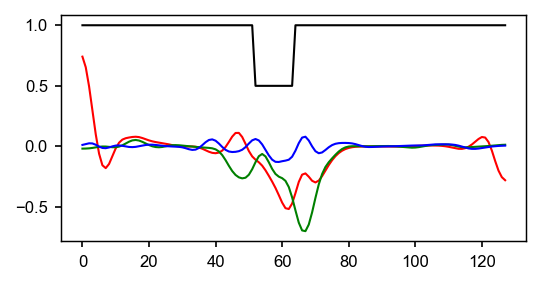

In [210]:
plt.plot(np.nanmean(tr(bar_st), 0)+1, 'k')
plt.plot(smooth_1d(np.nanmean(d_out[0]['gmtr']['c']['all']['diff'], 0), 2.5), 'r')
plt.plot(smooth_1d(np.nanmean(d_out[1]['gmtr']['c']['all']['diff'], 0), 2.5), 'g')
plt.plot(smooth_1d(np.nanmean(d_out[2]['gmtr']['c']['all']['diff'], 0), 2.5), 'b')

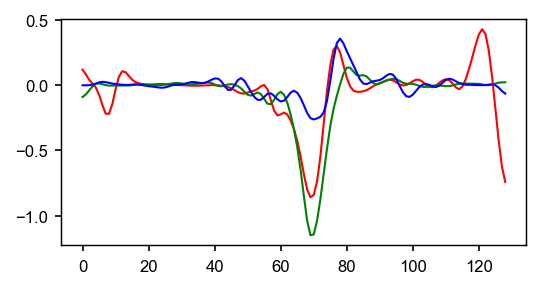

In [156]:
plt.plot(smooth_1d(np.nanmean(d_out[0]['gmtr']['c']['all']['diff'], 1), 2), 'r')
plt.plot(smooth_1d(np.nanmean(d_out[1]['gmtr']['c']['all']['diff'], 1), 2), 'g')
plt.plot(smooth_1d(np.nanmean(d_out[2]['gmtr']['c']['all']['diff'], 1), 2), 'b')

In [157]:
gm, gmtr = analyzeall_g_mb_st_cen_i(mb_num_space_bins=128, g_list=class_01_idx_g, ex=ex, df=df, stim_list=g_mb_exp_list, s1=0, s2=0)

<ipython-input-25-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-25-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

In [160]:
gmtr['c']['1'].keys()

dict_keys(['con', 'amp', 'dim', 'amp_con', 'dim_con', 'diff', 'amp_con_sm', 'dim_con_sm', 'diff_sm', 'diff_sm_slice'])

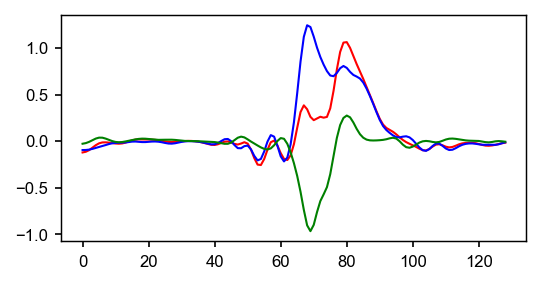

In [205]:
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['amp_con'], 1), 2), 'r')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['dim_con'], 1), 2), 'b')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['diff'], 1), 2), 'g')

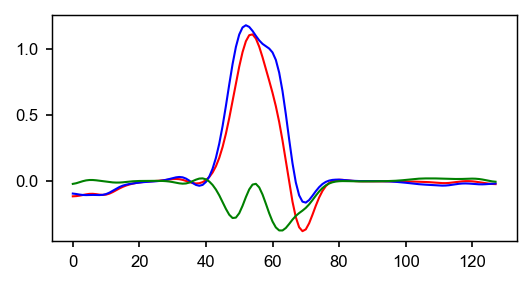

In [206]:
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['amp_con'], 0), 3), 'r')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['dim_con'], 0), 3), 'b')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['1']['diff'], 0), 3), 'g')

In [162]:
gmtr['c']['2'].keys()

dict_keys(['con', 'amp', 'dim', 'amp_con', 'dim_con', 'diff', 'amp_con_sm', 'dim_con_sm', 'diff_sm', 'diff_sm_slice'])

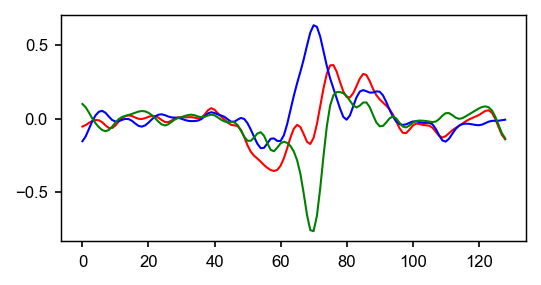

In [207]:
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['amp_con'], 1), 2), 'r')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['dim_con'], 1), 2), 'b')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['diff'], 1), 2), 'g')

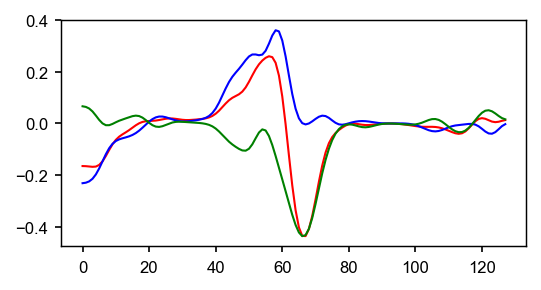

In [208]:
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['amp_con'], 0), 3), 'r')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['dim_con'], 0), 3), 'b')
plt.plot(smooth_1d(np.nanmean(gmtr['c']['2']['diff'], 0), 3), 'g')

In [230]:
bstr[0]['gmtr']['c'].keys()

dict_keys(['1', '2', '4', 'all', 'ns', 'lin', 'ln'])

In [231]:
bstr[0]['gm']['c']['lin'].keys()

dict_keys(['con'])

<ipython-input-232-08eb46088a05>:1: RuntimeWarning: Mean of empty slice
  plt.plot(smooth_1d(np.nanmean(np.nanmean(np.stack([bstr[n]['gmtr']['c']['all']['diff'] for n in range(30)]), 0), 1), 3)*30, 'r')
<ipython-input-232-08eb46088a05>:2: RuntimeWarning: Mean of empty slice
  plt.plot(smooth_1d(np.nanmean(np.nanmean(np.stack([bstr[n]['gmtr']['c']['ln']['con'] for n in range(30)]), 0), 1), 3))


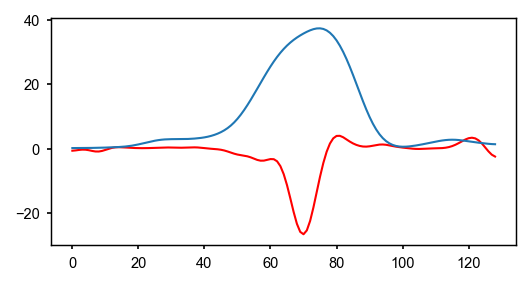

In [232]:
plt.plot(smooth_1d(np.nanmean(np.nanmean(np.stack([bstr[n]['gmtr']['c']['all']['diff'] for n in range(30)]), 0), 1), 3)*30, 'r')
plt.plot(smooth_1d(np.nanmean(np.nanmean(np.stack([bstr[n]['gmtr']['c']['ln']['con'] for n in range(30)]), 0), 1), 3))

In [233]:
np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 2)) for n in range(30)])

array([67, 63, 68, 68, 67, 68, 67, 68, 64, 65, 66, 67, 66, 65, 64, 68, 67,
       69, 63, 67, 67, 68, 68, 68, 68, 68, 68, 68, 65, 68])

(array([ 0.,  0.,  1.,  6., 13., 19., 13., 17., 16., 15.,  0.,  0.,  0.,
         0.,  0.,  0.]),
 array([57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73.]),
 <BarContainer object of 16 artists>)

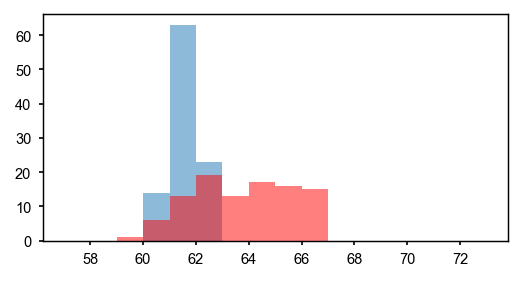

In [319]:
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['con'], 0), 4)) for n in range(100)]), 16, (57, 73), alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='r', alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['2']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='g', alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 8)) for n in range(100)]), 16, (57, 73), color='b', alpha=0.3)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11., 17., 42., 27.,  3.,
         0.,  0.,  0.]),
 array([57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73.]),
 <BarContainer object of 16 artists>)

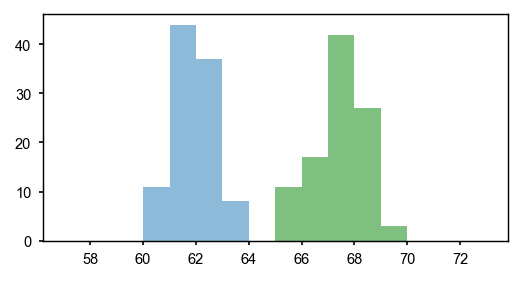

In [318]:
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['2']['con'], 0), 4)) for n in range(100)]), 16, (57, 73), alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='r', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['2']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='g', alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 8)) for n in range(100)]), 16, (57, 73), color='b', alpha=0.3)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16., 21., 40., 22.,  1.,
         0.,  0.,  0.]),
 array([57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73.]),
 <BarContainer object of 16 artists>)

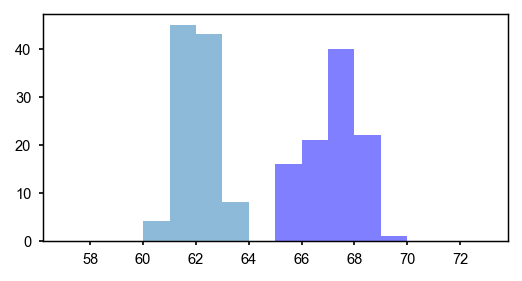

In [357]:
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['con'], 0), 4)) for n in range(100)]), 16, (57, 73), alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='r', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 4)) for n in range(100)]), 16, (57, 73), color='b', alpha=0.5)
#plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 8)) for n in range(100)]), 16, (57, 73), color='b', alpha=0.3)

In [298]:
scipy.stats.ttest_rel(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['con'], 0), 4)) for n in range(100)]), 
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['1']['diff'], 0), 4)) for n in range(100)]))

Ttest_relResult(statistic=-11.855157041411154, pvalue=1.0474555593379295e-20)

In [299]:
scipy.stats.ttest_rel(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['2']['con'], 0), 4)) for n in range(100)]), 
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['2']['diff'], 0), 4)) for n in range(100)]))

Ttest_relResult(statistic=-54.661557747690665, pvalue=9.175617598683571e-76)

In [300]:
scipy.stats.ttest_rel(np.stack([np.argmax(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['con'], 0), 4)) for n in range(100)]), 
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr[n]['gmtr']['c']['all']['diff'], 0), 4)) for n in range(100)]))

Ttest_relResult(statistic=-49.5318214916729, pvalue=1.1256698496816218e-71)

In [147]:
scipy.stats.ttest_1samp(bstr['1']['p1_p0'], 0), scipy.stats.ttest_1samp(bstr['2']['p1_p0'], 0), scipy.stats.ttest_1samp(bstr['4']['p1_p0'], 0), scipy.stats.ttest_1samp(bstr['all']['p1_p0'], 0)

(Ttest_1sampResult(statistic=-4.203046086987746, pvalue=2.8693445005078344e-05),
 Ttest_1sampResult(statistic=71.72162597682728, pvalue=0.0),
 Ttest_1sampResult(statistic=10.746384255357228, pvalue=1.4456941818499978e-25),
 Ttest_1sampResult(statistic=19.072971835169888, pvalue=2.1146372789953899e-69))

In [330]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_02_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   session
                    (df['mb_ad'] == 1) & (df['mb_ns'] == 1) &
#                   distance                             
#                    (df['i_g_idx1'] < 150 * (17/100)) & (df['i_g_idx1'] > -150 * (17/100)) &
                    (df['i_g_dist'] < 200) &
#                   location index is roughly at rf center
                    (df['f_rf'] == 1) & 
#                   ganglion cell rf center
                    (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                    (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                    (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                    (df['g_mb_con_cc_pair'] > 0.12) &
                    (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                    (df['i_mb_lin_line_cc_mean'] > 0.6) 
#                    (~(df['exp_id'] == 1) & ~(df['exp_id'] == 9))
                   ].index
class_02_idx_i = df.iloc[class_02_idx_g]['exp_id'].unique()
class_02_idx_g.shape, class_02_idx_i.shape

((18,), (3,))

In [331]:
bstr2 = bootstrap_g_mb(N=100, g_list=class_02_idx_g, seed=101, s1=2, s2=2)   # Takes long time

<ipython-input-24-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  2.,  6., 16., 22., 19., 14., 15.,
         6.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
        53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.,
        66., 67., 68., 69., 70., 71., 72., 73.]),
 <BarContainer object of 33 artists>)

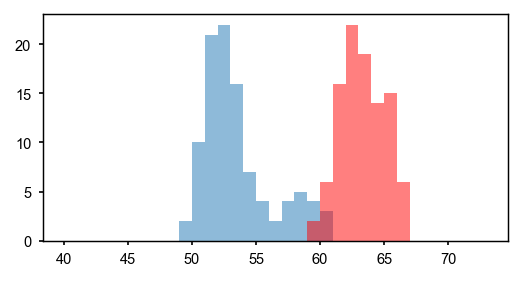

In [379]:
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['ns']['diff'], 0), 8)) for n in range(100)]), 33, (40, 73), alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['1']['diff'], 0), 8)) for n in range(100)]), 33, (40, 73), color='r', alpha=0.5)

In [382]:
scipy.stats.ttest_rel(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['ns']['diff'], 0), 8)) for n in range(100)]), 
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['1']['diff'], 0), 8)) for n in range(100)]))

Ttest_relResult(statistic=-34.54849200591153, pvalue=4.8581110999758185e-57)

(array([ 0.,  0.,  5., 62., 32.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.]),
 array([66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
        79., 80.]),
 <BarContainer object of 14 artists>)

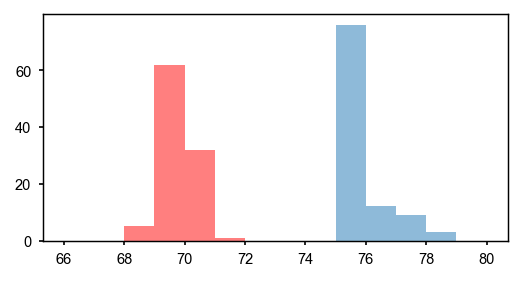

In [381]:
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['ns']['diff'], 1), 3)) for n in range(100)]), 14, (66, 80), alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['1']['diff'], 1), 3)) for n in range(100)]), 14, (66, 80), color='r', alpha=0.5)

In [384]:
scipy.stats.ttest_rel(np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['ns']['diff'], 1), 3)) for n in range(100)]), 
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr2[n]['gmtr']['c']['1']['diff'], 1), 3)) for n in range(100)]))

Ttest_relResult(statistic=56.11183887147579, pvalue=7.44076263001822e-77)

In [389]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_03_idx_g = df[((df['g_classify_idx'] == 0) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
#                    (df['i_g_idx1'] < 150 * (17/100)) & (df['i_g_idx1'] > -150 * (17/100)) &
                    (df['i_g_dist'] < 200) &
#                   location index is roughly at rf center
                    (df['f_rf'] == 1) & 
#                   ganglion cell rf center
                    (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                    (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                    (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                    (df['g_mb_con_cc_pair'] > 0.12) &
                    (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                    (df['i_mb_lin_line_cc_mean'] > 0.6) 
#                    (~(df['exp_id'] == 1) & ~(df['exp_id'] == 9))
                   ].index
class_03_idx_i = df.iloc[class_03_idx_g]['exp_id'].unique()
class_03_idx_g.shape, class_03_idx_i.shape

((20,), (7,))

In [390]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_04_idx_g = df[((df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 1) | 
                     (df['g_classify_idx'] == 1)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
#                    (df['i_g_idx1'] < 150 * (17/100)) & (df['i_g_idx1'] > -150 * (17/100)) &
                    (df['i_g_dist'] < 200) &
#                   location index is roughly at rf center
                    (df['f_rf'] == 1) & 
#                   ganglion cell rf center
                    (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                    (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                    (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                    (df['g_mb_con_cc_pair'] > 0.12) &
                    (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                    (df['i_mb_lin_line_cc_mean'] > 0.6) 
#                    (~(df['exp_id'] == 1) & ~(df['exp_id'] == 9))
                   ].index
class_04_idx_i = df.iloc[class_04_idx_g]['exp_id'].unique()
class_04_idx_g.shape, class_04_idx_i.shape

((20,), (8,))

In [391]:
#                   ganglion class                  intracell class                moving bar (intracell)
class_05_idx_g = df[((df['g_classify_idx'] == 4) | 
                     (df['g_classify_idx'] == 4) | 
                     (df['g_classify_idx'] == 4)) & (df['i_classify_idx'] == 0) & ((df['i_mb_classify_idx'] == 0) | 
                                                                                   (df['i_mb_classify_idx'] == 2) |
                                                                                   (df['i_mb_classify_idx'] == 3) |
                                                                                   (df['i_mb_classify_idx'] == 4)) &
#                   distance                             
#                    (df['i_g_idx1'] < 150 * (17/100)) & (df['i_g_idx1'] > -150 * (17/100)) &
                    (df['i_g_dist'] < 200) &
#                   location index is roughly at rf center
                    (df['f_rf'] == 1) & 
#                   ganglion cell rf center
                    (df['cen_g_idx1'] > -128) & (df['cen_g_idx1'] < 128) & 
                    (df['cen_g_idx2'] > -128) & (df['cen_g_idx2'] < 128) &
#                   ganglion cell firing rate ('rf_30m')
                    (df['g_fr_rf_30m'] > 0.2) &
#                   ganglion cell correlation across trials ('mb'; control) & correlation to linear-nonlinear prediction
                    (df['g_mb_con_cc_pair'] > 0.12) &
                    (df['g_mb_ln_cc_mean'] > 0.05) &
#                   intracell correlation to linear prediction
                    (df['i_mb_lin_line_cc_mean'] > 0.6) 
#                    (~(df['exp_id'] == 1) & ~(df['exp_id'] == 9))
                   ].index
class_05_idx_i = df.iloc[class_05_idx_g]['exp_id'].unique()
class_05_idx_g.shape, class_05_idx_i.shape

((29,), (10,))

In [394]:
bstr3 = bootstrap_g_mb(N=100, g_list=class_03_idx_g, seed=101, s1=2, s2=2)   # Takes long time  #0 (fastest RGC)
bstr4 = bootstrap_g_mb(N=100, g_list=class_04_idx_g, seed=101, s1=2, s2=2)   # Takes long time  #1 (slowest RGC)
bstr5 = bootstrap_g_mb(N=100, g_list=class_05_idx_g, seed=101, s1=2, s2=2)   # Takes long time  #4

<ipython-input-24-ff0822ee4ccf>:47: RuntimeWarning: Mean of empty slice
  gm['s'][li]['con'] = np.nanmean(np.stack([d['s'][li][0, 0, :, :], d['s'][li][1, 0, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:50: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp'] = np.nanmean(np.stack([d['s'][li][0, 1, :, :], d['s'][li][1, 1, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:53: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim'] = np.nanmean(np.stack([d['s'][li][0, 2, :, :], d['s'][li][1, 2, :, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:60: RuntimeWarning: Mean of empty slice
  gm['s'][li]['amp_con'] = np.nanmean(np.stack([gm['s'][li]['amp_con_l'], gm['s'][li]['amp_con_r'][:, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:63: RuntimeWarning: Mean of empty slice
  gm['s'][li]['dim_con'] = np.nanmean(np.stack([gm['s'][li]['dim_con_l'], gm['s'][li]['dim_con_r'][:, ::-1]]), axis=0)
<ipython-input-24-ff0822ee4ccf>:66: RuntimeWarning: Mean of empty slice
  gm['s'][li]['

(array([ 0.,  0.,  0.,  1.,  0.,  0.,  2.,  8., 25., 27., 11.,  6.,  6.,
         3.,  8.]),
 array([60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71., 72.,
        73., 74., 75.]),
 <BarContainer object of 15 artists>)

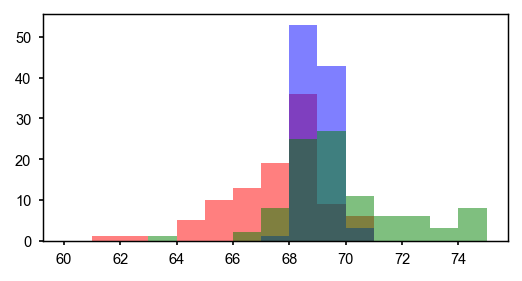

In [534]:
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]), 15, (60, 75), color='r', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]), 15, (60, 75), color='b', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]), 15, (60, 75), color='g', alpha=0.5)

In [535]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]))

Ttest_indResult(statistic=-7.55305011889815, pvalue=1.531787629483328e-12)

In [536]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]))

Ttest_indResult(statistic=-4.614378945114856, pvalue=7.0743376838491046e-06)

In [537]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 1), 6)) for n in range(100)]))

Ttest_indResult(statistic=-8.401569253109031, pvalue=8.470109581264033e-15)

(array([ 0.,  1.,  1.,  2.,  5., 13., 11.,  7., 24., 28.,  6.,  0.,  1.,
         0.,  0.]),
 array([50., 52., 54., 56., 58., 60., 62., 64., 66., 68., 70., 72., 74.,
        76., 78., 80.]),
 <BarContainer object of 15 artists>)

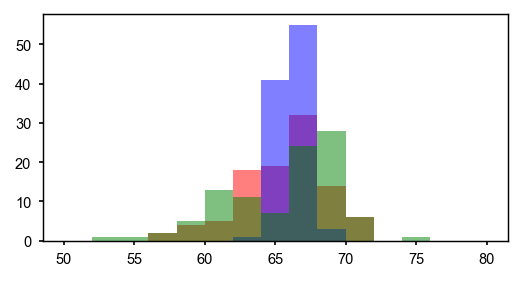

In [542]:
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]), 15, (50, 80), color='r', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]), 15, (50, 80), color='b', alpha=0.5)
plt.hist(np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]), 15, (50, 80), color='g', alpha=0.5)

In [540]:
np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]).mean(), np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]).mean(),np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]).mean()

(65.01, 65.79, 65.03)

In [531]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]))

Ttest_indResult(statistic=-2.4621288642664765, pvalue=0.014666377242413816)

In [532]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]))

Ttest_indResult(statistic=1.742402065785403, pvalue=0.08299078884972406)

In [533]:
scipy.stats.ttest_ind(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]),
                      np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]))

Ttest_indResult(statistic=-0.0381567278470653, pvalue=0.9696011656497889)

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 16., 18., 15., 30., 16.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]),
 array([50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.,
        63., 64., 65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75.,
        76., 77., 78., 79., 80.]),
 <BarContainer object of 30 artists>)

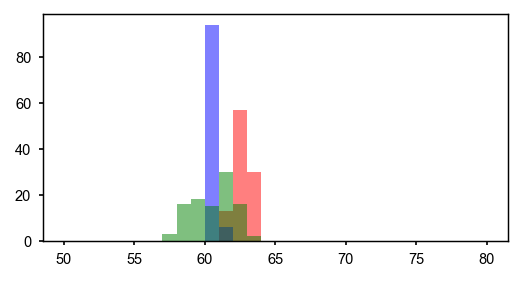

In [491]:
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 30, (50, 80), color='r', alpha=0.5)
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 30, (50, 80), color='b', alpha=0.5)
plt.hist(np.stack([np.argmax(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 30, (50, 80), color='g', alpha=0.5)

In [493]:
scipy.stats.ttest_1samp(np.stack([np.argmin(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]) - np.stack([np.argmax(smooth_1d(np.nanmean(bstr3[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 0)

Ttest_1sampResult(statistic=9.539535378086256, pvalue=1.1057253146480457e-15)

In [494]:
scipy.stats.ttest_1samp(np.stack([np.argmin(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]) - np.stack([np.argmax(smooth_1d(np.nanmean(bstr5[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 0)

Ttest_1sampResult(statistic=63.85807383784186, pvalue=2.8842598238202355e-82)

In [495]:
scipy.stats.ttest_1samp(np.stack([np.argmin(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['diff'], 0), 6)) for n in range(100)]) - np.stack([np.argmax(smooth_1d(np.nanmean(bstr4[n]['gmtr']['c']['all']['con'], 0), 6)) for n in range(100)]), 0)

Ttest_1sampResult(statistic=13.729714914264534, pvalue=1.1842574433511729e-24)

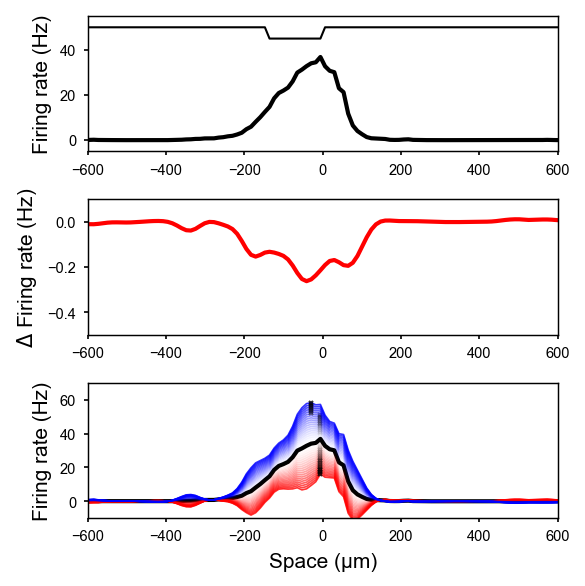

In [432]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(311)
ax.plot(sbins, np.nanmean(tr(bar_st)[20:, :], 0) * 10 + 50, 'k')
ax.plot(sbins, np.nanmean(g_mat_con_c_tr, 0), 'k', linewidth=2)
ax.set_xlim([-600, 600])
ax.set_ylim([-5, 55])
ax.set_ylabel('Firing rate (Hz)')
ax = plt.subplot(312)
ax.plot(sbins, g_mat_de_c_space, 'r', linewidth= 2)
ax.set_xlim([-600, 600])
ax.set_ylim([-0.5, 0.1])
ax.set_ylabel('$\Delta$ Firing rate (Hz)')
ax = plt.subplot(313)
ax.plot(sbins, np.nanmean(g_mat_con_c_tr, 0), 'k', linewidth=2)
for g_a in intracell_gain_a:
    ax.plot(sbins, np.nanmean(g_mat_con_c_tr, 0) + g_a * g_mat_de_c_space, 'r', linewidth=0.8, alpha=0.8*(g_a/np.max(intracell_gain_a))**1.5)
    ax.plot(sbins[np.argmax(np.nanmean(g_mat_con_c_tr, 0) + g_a * g_mat_de_c_space)], 
            np.max(np.nanmean(g_mat_con_c_tr, 0) + g_a * g_mat_de_c_space), 'kx', alpha=0.8*(g_a/np.max(intracell_gain_a))**1.5)
for g_d in intracell_gain_d:
    ax.plot(sbins, np.nanmean(g_mat_con_c_tr, 0) + g_d * g_mat_de_c_space, 'b', linewidth=0.8, alpha=0.8*(g_d/np.min(intracell_gain_d))**1.5)
    ax.plot(sbins[np.argmax(np.nanmean(g_mat_con_c_tr, 0) + g_d * g_mat_de_c_space)], 
            np.max(np.nanmean(g_mat_con_c_tr, 0) + g_d * g_mat_de_c_space), 'kx', alpha=0.8*(g_d/np.min(intracell_gain_d))**1.5)
ax.set_xlim([-600, 600])
ax.set_ylim([-10, 70])
ax.set_xlabel('Space (\u03bcm)')
ax.set_ylabel('Firing rate (Hz)')
plt.tight_layout()
#plt.savefig('fig6.png', dpi=300)

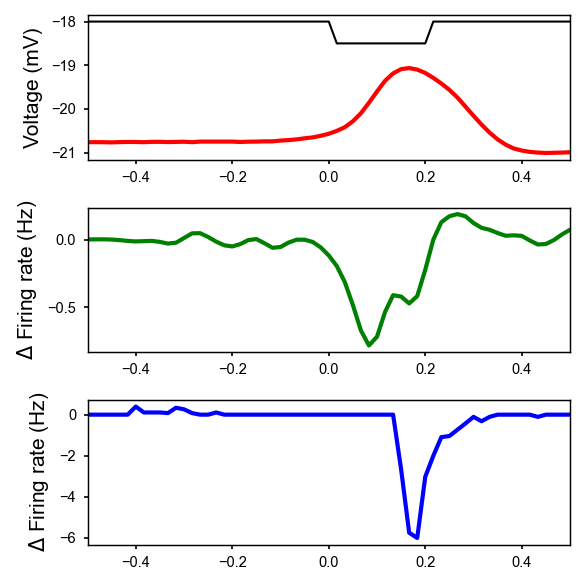

In [426]:
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(311)
ax.plot(tbins, bar_st[:, 64] - 18, 'k')
ax.plot(tbins, np.nanmean(i_mb_cen_i, (0, 1, 2)), 'r', linewidth=2)
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('Voltage (mV)')
ax = plt.subplot(312)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 64-param_range:64+param_range], 1), 'g', linewidth=2)
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('$\Delta$ Firing rate (Hz)')
ax = plt.subplot(313)
ax.plot(tbins, np.nanmean(g_mb_ns_st_cen_i_c[0] - g_mb_ns_st_cen_i_c[1], 1), 'b', linewidth=2)
ax.set_xlim([-0.5, 0.5])
ax.set_ylabel('$\Delta$ Firing rate (Hz)')
plt.tight_layout()
#plt.savefig('fig8.png', dpi=300)

### 2-06. Bootstrap analysis

In [ ]:
# index for bootstrap
classify_01_bs1_idx_g = classify_01_idx_g & df[((df['g_4px_binspace_idx_cen_i'] >= 44) & (df['g_4px_binspace_idx_cen_i'] < 49)) | 
                                               ((df['g_4px_binspace_idx_cen_i'] >= 79) & (df['g_4px_binspace_idx_cen_i'] < 84))].index
classify_01_bs2_idx_g = classify_01_idx_g & df[((df['g_4px_binspace_idx_cen_i'] >= 49) & (df['g_4px_binspace_idx_cen_i'] < 54)) | 
                                               ((df['g_4px_binspace_idx_cen_i'] >= 74) & (df['g_4px_binspace_idx_cen_i'] < 79))].index
classify_01_bs3_idx_g = classify_01_idx_g & df[((df['g_4px_binspace_idx_cen_i'] >= 54) & (df['g_4px_binspace_idx_cen_i'] < 59)) | 
                                               ((df['g_4px_binspace_idx_cen_i'] >= 69) & (df['g_4px_binspace_idx_cen_i'] < 74))].index
classify_01_bs4_idx_g = classify_01_idx_g & df[((df['g_4px_binspace_idx_cen_i'] >= 59) & (df['g_4px_binspace_idx_cen_i'] < 64)) | 
                                               ((df['g_4px_binspace_idx_cen_i'] >= 64) & (df['g_4px_binspace_idx_cen_i'] < 69))].index
len(classify_01_bs1_idx_g), len(classify_01_bs2_idx_g), len(classify_01_bs3_idx_g), len(classify_01_bs4_idx_g)

In [89]:
def bs_analyze_g_mb_st_cen_i(N=10,
                             g_mb_exp_idx=3,
                             mb_num_space_bins=128, 
                             g_list=g_list,
                             ex=ex,
                             df=df):
    m = g_list.shape[0]
    g_mb_exp_list = [1, 2, 4, 'all']
    param_range = 20
    peak_diff_mat = np.zeros((N, 2*param_range))
    for i in range(N):
        bs_g_list = np.random.choice(g_list, m, replace=True)
        [g_mb_1_st_cen_i_c, 
         g_mb_2_st_cen_i_c, 
         g_mb_4_st_cen_i_c, 
         g_mb_all_st_cen_i_c, 
         g_mb_ns_st_cen_i_c] = analyze_g_mb_st_cen_i(mb_num_space_bins=128, g_list=bs_g_list, ex=ex, df=df, mode='cells')
        
        g_mb_st_cen_i_c = vars()['g_mb_' + str(g_mb_exp_list[g_mb_exp_idx]) + '_st_cen_i_c']

        g_mat = np.nanmean(np.stack([g_mb_st_cen_i[0, 0, :, :], g_mb_st_cen_i[1, 0, :, ::-1]]), axis=0)
        g_mat[np.isnan(g_mat)] = 0

        g_diff_mat_l = g_mb_st_cen_i[0, 1, :, :] - g_mb_st_cen_i[0, 2, :, :]
        g_diff_mat_r = g_mb_st_cen_i[1, 1, :, :] - g_mb_st_cen_i[1, 2, :, :]
        g_diff_mat = np.nanmean(np.stack([g_diff_mat_l, g_diff_mat_r[:, ::-1]]), axis=0)
        g_diff_mat[np.isnan(g_diff_mat)]=0
        g_diff_mat = scipy.ndimage.gaussian_filter(g_diff_mat, [1, 2])
        peak_diff = (tbins[np.argmin(g_diff_mat[:, 64-param_range:64+param_range], 0)] - tbins[np.argmax(g_mat[:, 64-param_range:64+param_range], 0)])
        peak_diff_mat[i, :] = peak_diff
    return peak_diff_mat

In [90]:
N = 10000
g_mb_bs_1 = bs_analyze_g_mb_st_cen_i(N=N, g_list=classify_01_bs1_idx_g)
g_mb_bs_2 = bs_analyze_g_mb_st_cen_i(N=N, g_list=classify_01_bs2_idx_g)
g_mb_bs_3 = bs_analyze_g_mb_st_cen_i(N=N, g_list=classify_01_bs3_idx_g)
g_mb_bs_4 = bs_analyze_g_mb_st_cen_i(N=N, g_list=classify_01_bs4_idx_g)

<ipython-input-89-102b6c5a9556>:21: RuntimeWarning: Mean of empty slice
  g_mat = np.nanmean(np.stack([g_mb_st_cen_i[0, 0, :, :], g_mb_st_cen_i[1, 0, :, ::-1]]), axis=0)
<ipython-input-89-102b6c5a9556>:26: RuntimeWarning: Mean of empty slice
  g_diff_mat = np.nanmean(np.stack([g_diff_mat_l, g_diff_mat_r[:, ::-1]]), axis=0)


In [91]:
g_mb_bs_total = np.zeros((N, 2*param_range))
g_mb_bs_total[:, :5] = g_mb_bs_1[:, :5]
g_mb_bs_total[:, -5:] = g_mb_bs_1[:, -5:]
g_mb_bs_total[:, 5:10] = g_mb_bs_2[:, 5:10]
g_mb_bs_total[:, -10:-5] = g_mb_bs_2[:, -10:-5]
g_mb_bs_total[:, 10:15] = g_mb_bs_3[:, 10:15]
g_mb_bs_total[:, -15:-10] = g_mb_bs_3[:, -15:-10]
g_mb_bs_total[:, 15:25] = g_mb_bs_4[:, 15:25]

In [331]:
N_g_mb_l = np.histogram(df.loc[classify_01_idx_g, :]['g_4px_binspace_idx_cen_i'], 40, (64-param_range, 64+param_range))[0]
N_g_mb_r = N_g_mb_l[::-1]
unit_g_mb = N_g_mb_l + N_g_mb_r

In [93]:
g_mb_bs_total_std = np.nanstd(g_mb_bs_total, axis=0)
g_mb_bs_total_sem = g_mb_bs_total_std / np.sqrt(unit_g_mb)

(-0.3333333333333333, 0.3333333333333333)

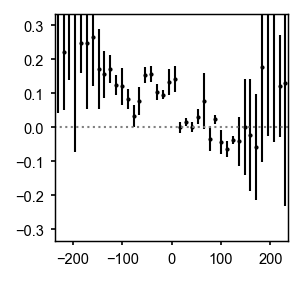

In [122]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.plot(sbins[64-param_range:64+param_range], np.nanmean(g_mb_bs_total, 0), 'k.')
ax.errorbar(sbins[64-param_range:64+param_range], y=np.nanmean(g_mb_bs_total, 0), yerr=g_mb_bs_total_sem, color='black', markersize=0, fmt='.')
ax.axhline(y=0, xmin=-300, xmax=300, color='gray', linestyle=':')
ax.set_xlim(s_lim)
#ax.set_xlim([-150, 150])
ax.set_ylim(t_lim)

(-0.3333333333333333, 0.3333333333333333)

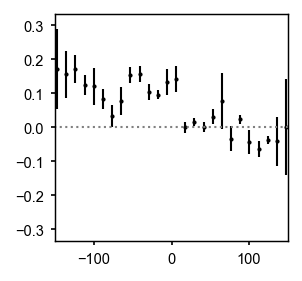

In [124]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
ax.plot(sbins[64-param_range:64+param_range], np.nanmean(g_mb_bs_total, 0), 'k.')
ax.errorbar(sbins[64-param_range:64+param_range], y=np.nanmean(g_mb_bs_total, 0), yerr=g_mb_bs_total_sem, color='black', markersize=0, fmt='.')
ax.axhline(y=0, xmin=-300, xmax=300, color='gray', linestyle=':')
#ax.set_xlim(s_lim)
ax.set_xlim([-150, 150])
ax.set_ylim(t_lim)

### 2-05. Compare peaks of responses

In [409]:
param_range = 20

In [410]:
model = sklearn.linear_model.LinearRegression()
model.fit(np.arange(64-param_range, 64+param_range).reshape(-1, 1), np.argmax(g_mat_con_c, 0)[64-param_range:64+param_range].reshape(-1, 1))
g_peak_hat = model.predict(np.arange(0, 128).reshape(-1, 1)).reshape(-1)

In [411]:
mat_temp = g_mat_de_c_smooth[64-param_range:64+param_range, 64-param_range:64+param_range]
mat_temp_com_idx = scipy.ndimage.center_of_mass(abs(np.where(mat_temp<0, mat_temp, 0)))
mat_com_idx = np.add(mat_temp_com_idx, ((64 - param_range), (64 - param_range)))
mat_com_idx

array([68.23805531, 63.15042915])

(-20.0, 20.0)

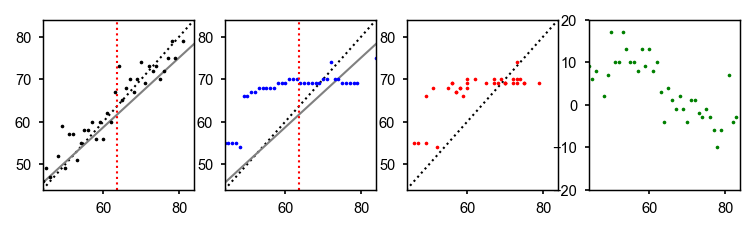

In [412]:
fig = plt.figure(figsize=(6, 1.5))
ax = plt.subplot(141)
ax.plot(np.arange(128), np.arange(128), 'k:')
ax.plot(np.arange(128), g_peak_hat, color='gray')
ax.plot(np.arange(128), np.argmax(g_mat_con_c, 0), 'k.', markersize=1.5)
ax.axvline(x=63.5, ymin=0, ymax=128, color='r', linestyle=':')
ax.set_xlim([64-param_range, 64+param_range])
ax.set_ylim([64-param_range, 64+param_range])
ax = plt.subplot(142)
ax.plot(np.arange(128), np.arange(128), 'k:')
ax.plot(np.arange(128), g_peak_hat, color='gray')
ax.plot(np.arange(128), np.argmin(g_mat_de_c_smooth, 0), 'b.', markersize=1.5)
#ax.plot(mat_com_idx[1], mat_com_idx[0], 'kx', markersize=5)
ax.axvline(x=63.5, ymin=0, ymax=128, color='r', linestyle=':')
ax.set_xlim([64-param_range, 64+param_range])
ax.set_ylim([64-param_range, 64+param_range])
ax = plt.subplot(143)
ax.plot(np.arange(128), np.arange(128), 'k:')
ax.plot(np.argmax(g_mat_con_c, 0), np.argmin(g_mat_de_c_smooth, 0), 'r.', markersize=1.5)
#ax.plot(model.predict(mat_com_idx[1].reshape(-1, 1)), mat_com_idx[0], 'b+', markersize=5)
ax.set_xlim([64-param_range, 64+param_range])
ax.set_ylim([64-param_range, 64+param_range])

ax = plt.subplot(144)
ax.plot(np.arange(128), np.argmin(g_mat_de_c_smooth, 0) - np.argmax(g_mat_con_c, 0), 'g.', markersize=1.5)
ax.set_xlim([64-param_range, 64+param_range])
ax.set_ylim([-20, 20])

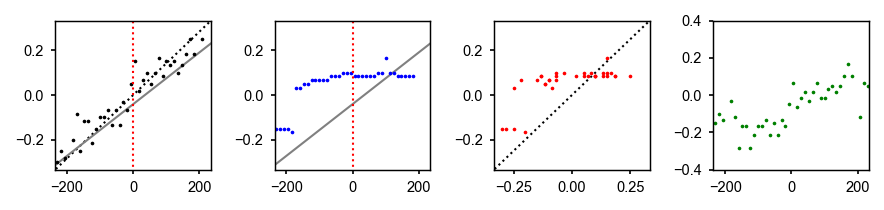

In [413]:
fig = plt.figure(figsize=(6, 1.5))
ax = plt.subplot(141)
ax.plot(sbins, s2t(sbins), 'k:')
ax.plot(sbins, idx2t(g_peak_hat), color='gray')
ax.plot(sbins, tbins[np.argmax(g_mat_con_c, 0)], 'k.', markersize=1.5)
ax.axvline(x=0, ymin=-1, ymax=1, color='r', linestyle=':')
ax.set_xlim(s_lim)
ax.set_ylim(t_lim)
ax = plt.subplot(142)
ax.plot(sbins, idx2t(g_peak_hat), color='gray')
ax.plot(sbins, tbins[np.argmin(g_mat_de_c_smooth, 0)], 'b.', markersize=1.5)
#ax.plot(idx2s(mat_com_idx[1]), idx2t(mat_com_idx[0]), 'kx', markersize=5)
ax.axvline(x=0, ymin=-1, ymax=1, color='r', linestyle=':')
ax.set_xlim(s_lim)
ax.set_ylim(t_lim)
ax = plt.subplot(143)
ax.plot(tbins, tbins, 'k:')
ax.plot(tbins[np.argmax(g_mat_con_c, 0)], tbins[np.argmin(g_mat_de_c_smooth, 0)], 'r.', markersize=1.5)
ax.set_xlim(t_lim)
ax.set_ylim(t_lim)
ax = plt.subplot(144)
ax.plot(sbins, (np.argmax(g_mat_con_c, 0) - np.argmin(g_mat_de_c_smooth, 0))*ex.tbins['mb_ad'][0][1], 'g.', markersize=1.5)
ax.set_xlim(s_lim)
ax.set_ylim([-0.4, 0.4])
plt.tight_layout()

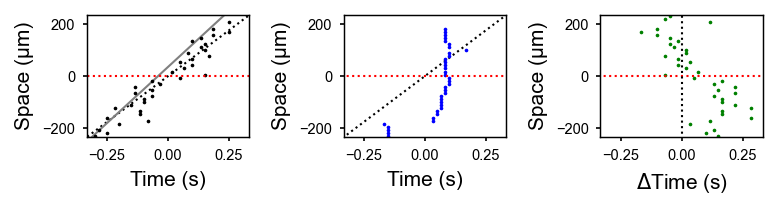

In [414]:
fig = plt.figure(figsize=(7, 1.5))
ax = plt.subplot(141)
ax.plot(s2t(sbins), sbins, 'k:')
ax.plot(idx2t(g_peak_hat), sbins, color='gray')
ax.plot(tbins[np.argmax(g_mat_con_c, 0)], sbins, 'k.', markersize=1.5)
ax.axhline(y=0, xmin=-1, xmax=1, color='r', linestyle=':')
ax.set_xlim(t_lim)
ax.set_ylim(s_lim)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Space (\u03bcm)')
ax = plt.subplot(142)
ax.plot(s2t(sbins), sbins, 'k:')
ax.plot(tbins[np.argmin(g_mat_de_c_smooth, 0)], sbins, 'b.', markersize=1.5)
#ax.plot(idx2t(mat_com_idx[0]), idx2s(mat_com_idx[1]), 'kx', markersize=4)
ax.axhline(y=0, xmin=-1, xmax=1, color='r', linestyle=':')
ax.set_xlim(t_lim)
ax.set_ylim(s_lim)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Space (\u03bcm)')
ax = plt.subplot(143)
ax.plot((np.argmin(g_mat_de_c_smooth, 0) - np.argmax(g_mat_con_c, 0))*ex.tbins['mb_ad'][0][1], sbins, 'g.', markersize=1.5)
ax.axhline(y=0, xmin=-1, xmax=1, color='r', linestyle=':')
ax.axvline(x=0, ymin=-1, ymax=1, color='k', linestyle=':')

#ax.plot(tbins[np.argmin(g_mat_de_c_smooth, 0)], tbins[np.argmax(g_mat_con_c, 0)], 'r.', markersize=1.5)
#ax.plot(np.nanmean(tbins[np.argmin(g_mat_de_c_smooth, 0)][64-param_range:64+param_range]),
#        np.nanmean(tbins[np.argmax(g_mat_con_c, 0)][64-param_range:64+param_range]), 'kx', markersize=4)
ax.set_xlim(t_lim)
ax.set_ylim(s_lim)
ax.set_xlabel('$\Delta$Time (s)')
ax.set_ylabel('Space (\u03bcm)')
#ax = plt.subplot(224)
#ax.hist((tbins[np.argmin(g_mat_de_c_smooth, 0)] - tbins[np.argmax(g_mat_con_c, 0)])[64-param_range:64+param_range], 25, color='red', alpha=0.3)
#ax.axvline(x=np.mean((tbins[np.argmin(g_mat_de_c_smooth, 0)] - tbins[np.argmax(g_mat_con_c, 0)])[64-param_range:64+param_range]), 
#           ymin=-1, ymax=10, color='r', linestyle=':')
#ax.set_xlim([-0.5, 0.5])
#ax.set_xlabel('Time (s)')
#ax.set_ylabel('# of space unit')
plt.tight_layout()
#plt.savefig('fig3.png', dpi=300)

NameError: name 'tbins' is not defined

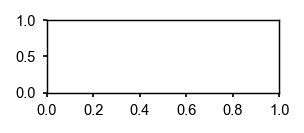

In [138]:
ts2st(bar_st)
fig = plt.figure(figsize=(2, 6))
ax = plt.subplot(818)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 44:49], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 44:49]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(817)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 49:54], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 49:54]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(816)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 54:59], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 54:59]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(815)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 59:64], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 59:64]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(814)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 64:69], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 64:69]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(813)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 69:74], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 69:74]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(812)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 74:79], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 74:79]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
ax = plt.subplot(811)
ax.plot(tbins, np.nanmean(g_mat_de_c_smooth[:, 79:84], 1), 'b')
ax.plot(tbins, np.nanmean(bar_st[:, 79:84]*2+2, 1), 'k')
ax.set_xlim(t_lim)
ax.set_ylim([-2, 2])
#plt.savefig('fig4.png', dpi=300)

In [ ]:
#################3
g_mat_con_s = np.nanmean(np.stack([g_mb_st_cen_i_s[0, 0, :, :], g_mb_st_cen_i_s[1, 0, :, ::-1]]), axis=0)
g_mat_con_s[np.isnan(g_mat_con_s)] = 0

g_mat_con_c = g_mb_st_cen_i_c[0, :, :]
g_mat_con_c[np.isnan(g_mat_con_c)] = 0

g_mat_de_l_s = (g_mb_st_cen_i_s[0, 1, :, :] - g_mb_st_cen_i_s[0, 2, :, :])
g_mat_de_r_s = (g_mb_st_cen_i_s[1, 1, :, :] - g_mb_st_cen_i_s[1, 2, :, :])
g_mat_de_s = np.nanmean(np.stack([g_mat_de_l_s, g_mat_de_r_s[:, ::-1]]), axis=0)
g_mat_de_l_s[np.isnan(g_mat_de_l_s)] = 0
g_mat_de_r_s[np.isnan(g_mat_de_r_s)] = 0
g_mat_de_s[np.isnan(g_mat_de_s)] = 0
g_mat_de_l_s_smooth = scipy.ndimage.gaussian_filter(g_mat_de_l_s, [1, 1])
g_mat_de_r_s_smooth = scipy.ndimage.gaussian_filter(g_mat_de_r_s, [1, 1])
g_mat_de_s_smooth = scipy.ndimage.gaussian_filter(g_mat_de_s, [1.5, 2])

g_mat_de_c = (g_mb_st_cen_i_c[1, :, :] - g_mb_st_cen_i_c[2, :, :])
g_mat_de_c[np.isnan(g_mat_de_c)] = 0
g_mat_de_c_smooth = scipy.ndimage.gaussian_filter(g_mat_de_c, [1.5, 2])

In [405]:
tbins = ex.tbins['mb_ad'][0] - ex.tbins['mb_ad'][0][64]# + ex.tbins['mb_ad'][0][1]/2
sbins = np.linspace(-127.5 * (100/17), 127.5 * (100/17), 128)
tbins.shape, sbins.shape

((129,), (128,))

In [406]:
tb = ex.tbins['mb_ad'][0] - ex.tbins['mb_ad'][0][64]
sb = np.linspace(-128 * (100/17), 128 * (100/17), 129)
def idx2t(n):
    model_idx2t = sklearn.linear_model.LinearRegression()
    model_idx2t.fit(np.arange(129).reshape(-1, 1), tbins.reshape(-1, 1))
    return model_idx2t.predict(n.reshape(-1, 1)).reshape(-1)
def idx2s(n):
    model_idx2s = sklearn.linear_model.LinearRegression()
    model_idx2s.fit(np.arange(128).reshape(-1, 1), sbins.reshape(-1, 1))
    return model_idx2s.predict(n.reshape(-1, 1)).reshape(-1)
def t2s(n):
    model_t2s = sklearn.linear_model.LinearRegression()
    model_t2s.fit(tb.reshape(-1, 1), sb.reshape(-1, 1))
    return model_t2s.predict(n.reshape(-1, 1)).reshape(-1)
def s2t(n):
    model_s2t = sklearn.linear_model.LinearRegression()
    model_s2t.fit(sb.reshape(-1, 1), tb.reshape(-1, 1))
    return model_s2t.predict(n.reshape(-1, 1)).reshape(-1)